# Cell 0 preparation 

In [1]:
# make the screen bigger!

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))


In [2]:
# make the screen bigger!

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))



# define the simple peak detect function
# comes from https://gist.github.com/endolith/250860 ,    see this for documentation
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []       
    if x is None:
        x = arange(len(v))    
    v = asarray(v)
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN  
    lookformax = True    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]       
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
    return array(maxtab), array(mintab)

# Cell 0: modules and addresses 

In [3]:
import os,sys
import pandas as pd
import datetime
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statistics as st
from matplotlib.pyplot import plot, scatter, show
import scipy.signal as signal
from scipy import stats
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import scipy
from scipy import stats


%matplotlib notebook


homedir = (r"E:\AmericanSamoa\Projects\ASPA_GUDI\Data_analysis\Turbidity_ecoli_part")
os.chdir(homedir)
rawdata = ("raw_data")
processed = ("processed")
hand_processed = ("processed/hand_processed")
path_raw_ecoli_data = ("Raw_ecoli_data")
path_printed_plots = ("Printed_plots")
 


# Cell 0: preparation of Airport rain data

In [4]:
# integrate the airport rainfall into the sheet too
os.chdir(homedir)

airport = pd.read_csv('Airport_rainfall.csv')
airport['Date'] = pd.to_datetime(airport['Date'], errors='coerce')  # string date to real date
airport = airport.dropna(subset = ['Date'], axis=0, how='any') # remove entries with messed up dates
airport = airport.replace(' ', '') # delete any  eronious spaces in the data
airport = airport.replace('', '0') # Convert any blanks to 0s in the data
airport['PPG_Precip'] = airport['Precip'].apply(lambda x: float(x))
airport['date']  = airport['Date']
del airport['Date']
del airport['Precip']

# Cell 1: reading all data files into memory (long run time)
This script takes turbidity files and makes them into kick ass plots
Note that the files need pre-processing in excel to make sure that they have: 
-C1 is date time
C2 is by the minute turbidity data
C3 is rainfall hourly with blanks as the minutes (rows) without data
- must be in CSV format with name as W'well number'
- must also not contain any extra rows, thus use a clean sheet each time to paste in raw data

Note: well 16 ws missing rainfall from 11-28-2012 to 12-2-2012. Airport rainfall indicated that there was 1.26 inches of rain on 12-2-2012 thus a value at 12-2-2012 00:00 was filled in with this rainfall total

C:\Users\cshuler\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\cshuler\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


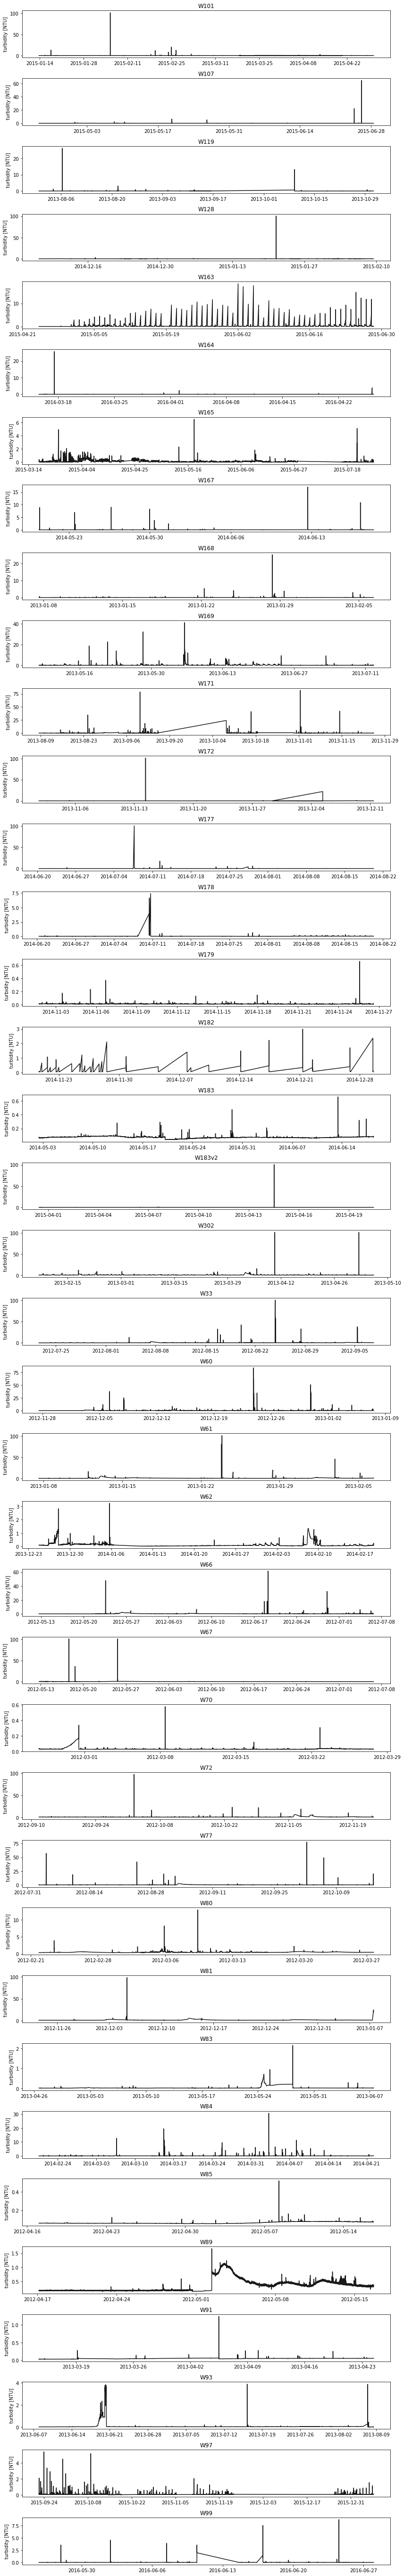

In [4]:
os.chdir(homedir)
os.chdir(rawdata)

plt.close("all")  # close previous figures to clear memory

files = os.listdir() # make a list of all the files in the directory

data = {}    #empty dictionary that will house all the files

p = 0   # subplot iterator
fig = plt.figure(figsize=(12,2*len(files)))


for i in files:    
    x = pd.read_csv(i)   # read each file
    key_name = i.split(".")[0] # name it as the well #
    x['date'] = pd.to_datetime(x['date'], errors='coerce')  # string date to real date
    x = x.dropna(subset = ['date'], axis=0, how='any') # remove entries with messed up dates
    x = x.replace(' ', '') # delete any  eronious spaces in the data
    x['rain'] = x['rain'].apply(lambda y: float(y))    # make sure all rain values are of float type 
        
        
#some code to just delete rows with non-consecutive dates
    x['delta'] = x['date'] - x['date'].shift(+1) # make new column with the difference between each row date
    #pd.options.mode.chained_assignment = None  # default='warn'  remove pesky warning message if needed Seems to set option if run once
    goodlist = x['delta'] == '0 days 00:01:00'   # if its not minute by minute data then...
    x = x[goodlist]  # remove it!
# its not the best and does tear out more data then needed but whatever    

    
# this whole damn block justs converts hourly rainfall into a column of daily rainfall. 
    x['daynum'] = x['date'].apply(lambda y: y.day).apply(str) # take the day
    x['monthnum'] = x['date'].apply( lambda y: y.month).apply(str) # And the month
    x['yearnum'] = x['date'].apply( lambda y: y.year).apply(str) # And the month
    x['MD_code'] = x['monthnum'] +"-"+ x['daynum']+ "-"+x['yearnum'] #make a code for the month and day
    del x['daynum'], x['monthnum'], x['yearnum']                  # remove excess columns  
    daily_rain = x.groupby('MD_code').sum() # group and sum all values based on the day of the date
    daily_rain['date'] = daily_rain.index # make a date column because the date value is stuck in the index
    daily_rain['date'] = pd.to_datetime(daily_rain['date'], errors='coerce') #make the string  a date
    daily_rain = daily_rain.filter(['date','rain'], axis=1)  #remove all the other random columns that were left from the original dataframe
    daily_rain.columns = ['date', 'daily_rain'] # rename the columns so that I can join to them and so that rain is not a replicate
    x = x.merge(daily_rain, how='left', on='date')  #stick the new daily rainfall totals on the by minute data, at the 00:00 time of each new day.
    x['daily_rain'] = x['daily_rain'].fillna(0)
# thats way too much code for this simple problem...

# merge the airport data
    x = x.merge(airport, how='left', on='date')
    x['PPG_Precip'] = x['PPG_Precip'].fillna(0)

        
# this generates a baseline value that is defined as the 25th quartile of the medians of 100 evenly spaced sample bins of the data set
    bin_size = round(len(x['NTU'])/100)
    da_meeds = []
    ind = 0
    for i in range(1,101): 
        win = x['NTU'][ind: i*bin_size]
        ind = ind + bin_size
        m = st.median(win)
        da_meeds.append(m)
    baseline = np.percentile(da_meeds, 25) # return 25th percentile,     
    x['baseline_val'] = baseline
    
#define heavy rain events, can change hourly rain rate value    
#start with the events that have an hourly rain rate of > whatever
    heavy = x['rain'] > 0.5                                       # this is a fairly arbitrary heavy rain event value, saw a worksheet that said heavy events are 10 to 40 mm? 
    events = x[heavy]                               # find times when an event occurs
    events = events[['date','rain']]                # reduce the columns 
    events.rename(columns = {'rain':'high_rain_rate_hrly'}, inplace = True) 

# now also define rain events where there was more than an inch of rain in 3 hrs
    hourlyraindat = pd.notnull(x['rain'])                   # find rows where there is a value
    dat = x[hourlyraindat]                                  
    dat['Rol_sum_3hr'] = dat['rain'].rolling(window=3,center=True).sum()
    dat['Rol_sum_3hr'] = dat['Rol_sum_3hr'].apply(lambda x: float(x))
    long_mong = dat['Rol_sum_3hr'] > 1
    daset = dat[long_mong]
    daset = daset[['date', 'Rol_sum_3hr']]
    daset = daset.merge(events, how='left', on='date') 
    daset['event_occurence'] = 1 
    x = x.merge(daset, how='left', on='date') 
    x['high_rain_rate_hrly'] = x['high_rain_rate_hrly'].apply(lambda x: float(x))
    x['Rol_sum_3hr'] = x['Rol_sum_3hr'].apply(lambda x: float(x))     
        
    data[key_name] = x      # make the dataframe key the first date name 
# plot some simple charts of each data file-    
    p = p+1 
    ax1 = fig.add_subplot(len(files),1,p)
    ax1.set_ylabel('turbidity [NTU]', color='k')
    ax1.tick_params('y', colors='k')
    ax1.plot(x['date'], x['NTU'], linestyle='-',  color='k', alpha=.9) 
    ax1.set_title(key_name)
    plt.tight_layout()



# Cell 2: filtering data 
this will also graph out the filtered data for exploration

106 days 08:51:00
65 days 14:01:00
92 days 00:46:00
64 days 13:31:00
64 days 20:36:00
41 days 08:58:00
132 days 00:04:00
28 days 13:10:00
29 days 07:51:00
65 days 03:27:00
108 days 11:30:00
39 days 06:15:00
60 days 13:07:00
60 days 12:42:00
24 days 10:47:00
30 days 07:57:00
46 days 13:39:00
19 days 14:20:00
87 days 10:36:00
46 days 15:24:00


C:\Users\cshuler\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


40 days 11:26:00
29 days 08:12:00
56 days 03:46:00
54 days 15:34:00
54 days 13:11:00
30 days 12:29:00
72 days 11:27:00
75 days 10:19:00
34 days 11:05:00
44 days 09:20:00
41 days 11:24:00
60 days 05:52:00
29 days 05:37:00
29 days 03:31:00
40 days 13:02:00
61 days 01:58:00
106 days 12:38:00
32 days 19:48:00


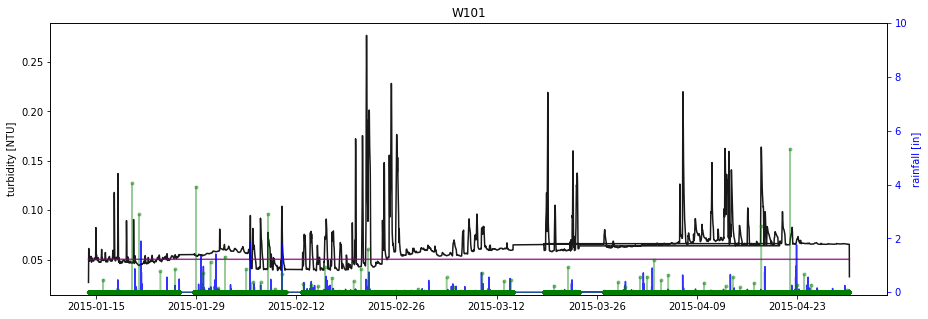

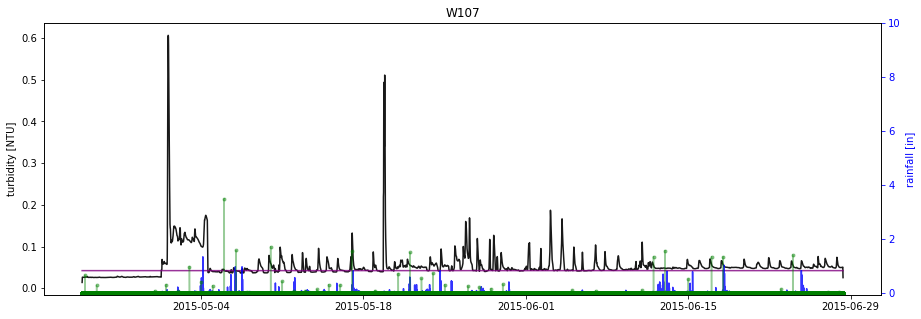

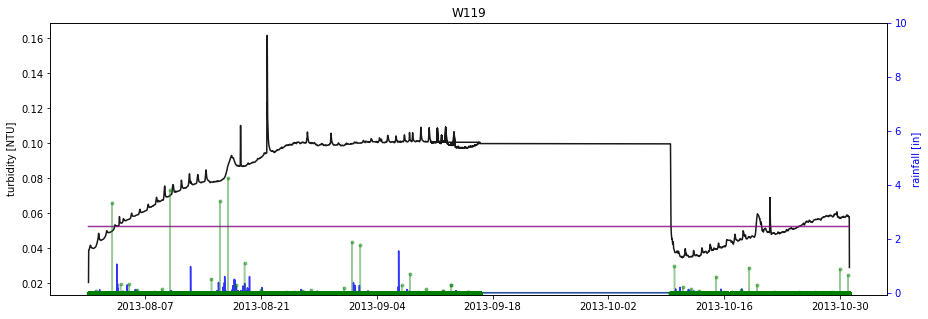

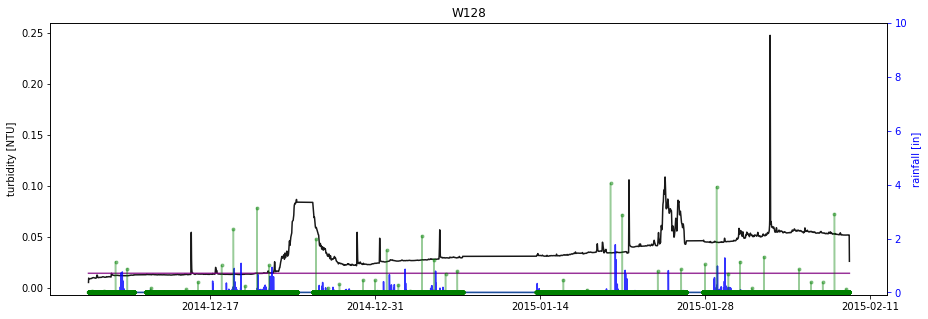

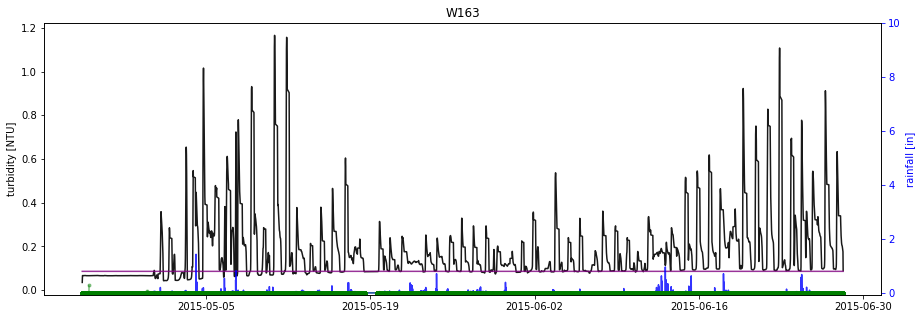

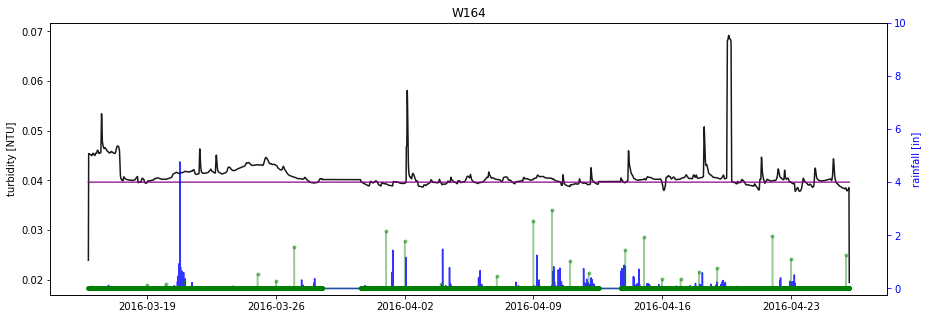

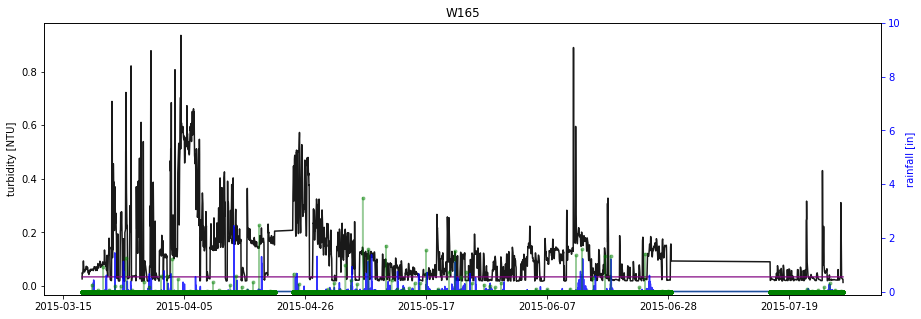

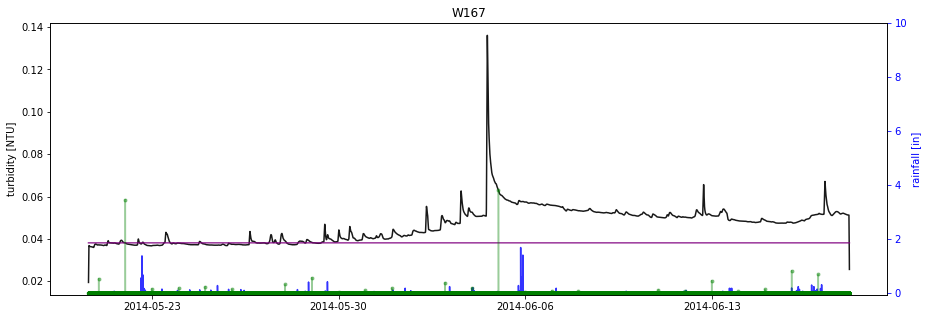

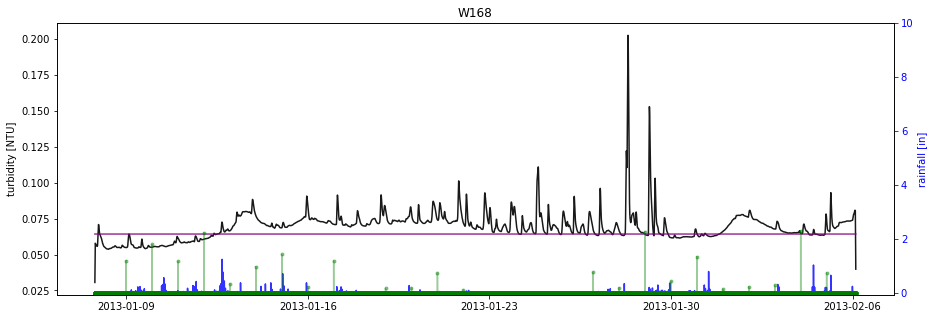

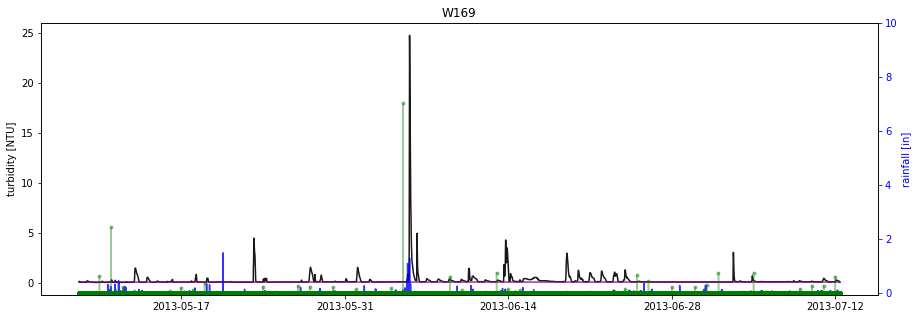

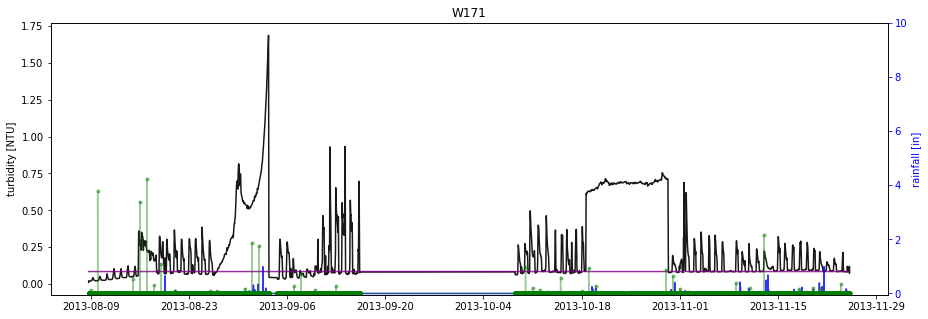

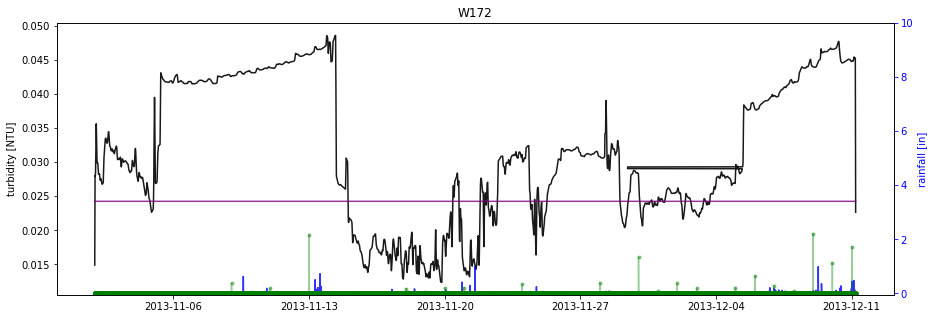

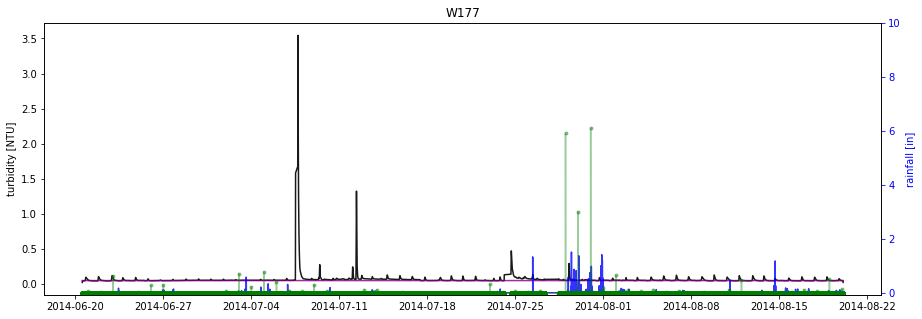

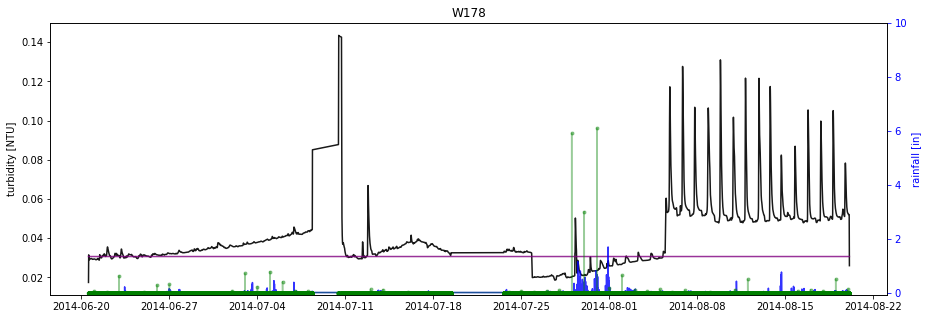

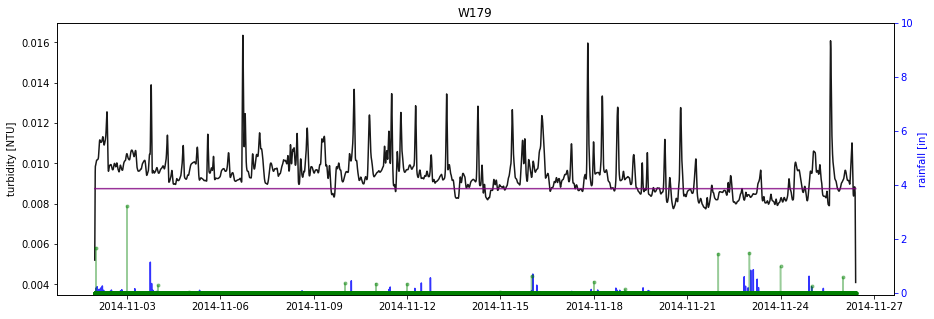

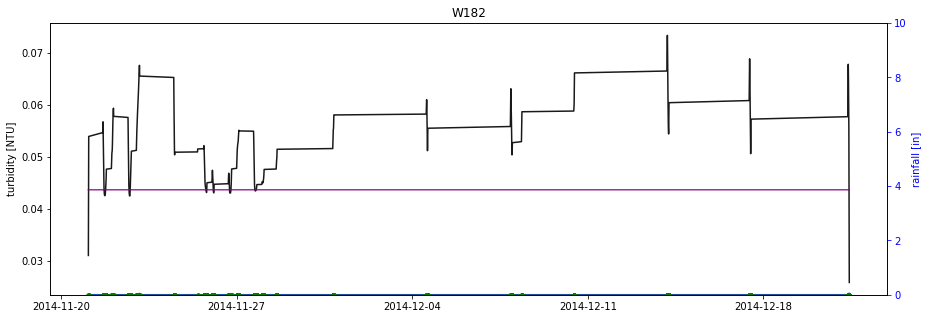

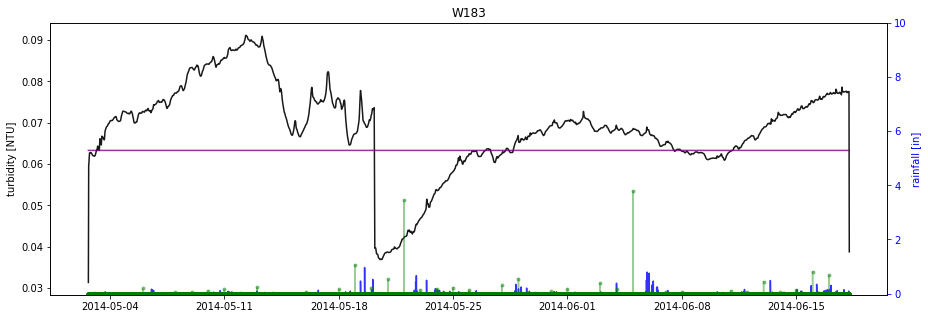

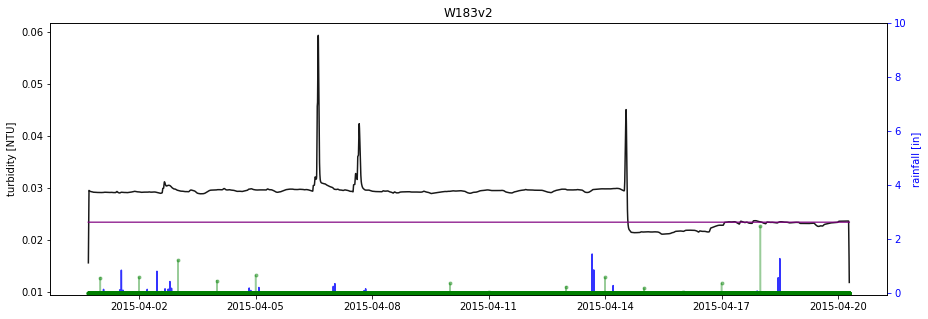

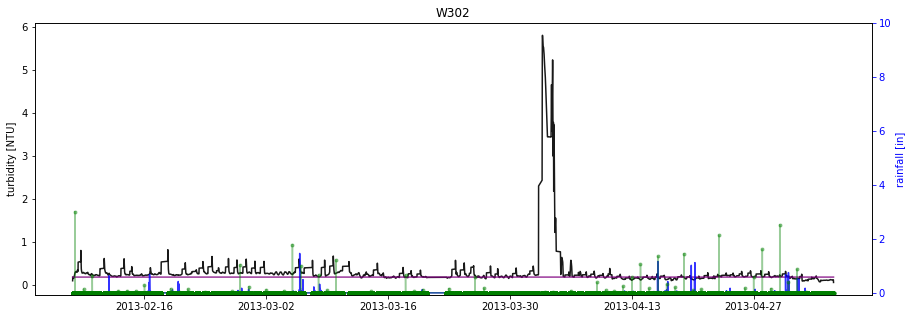

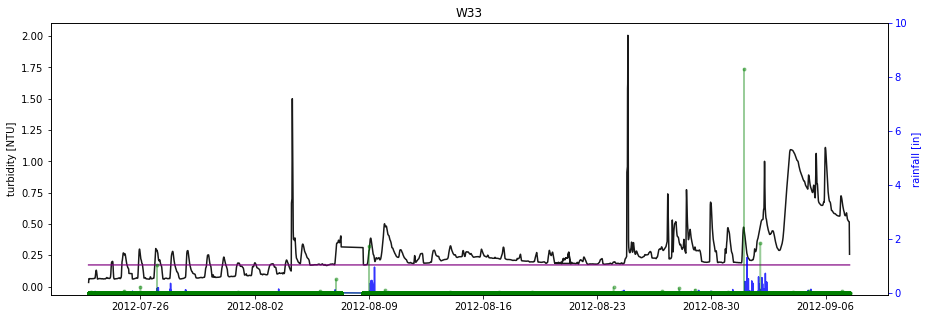

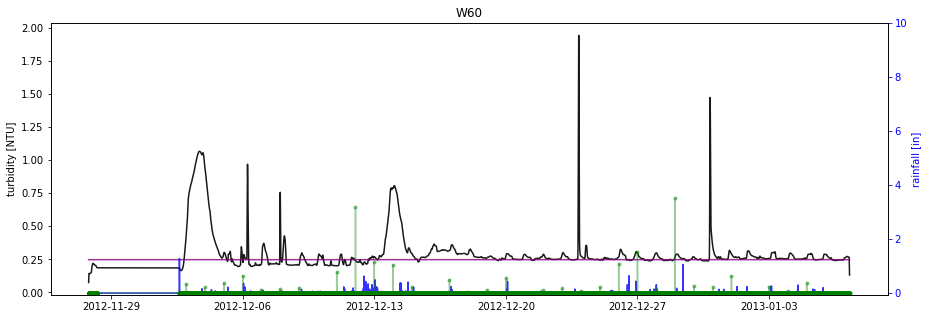

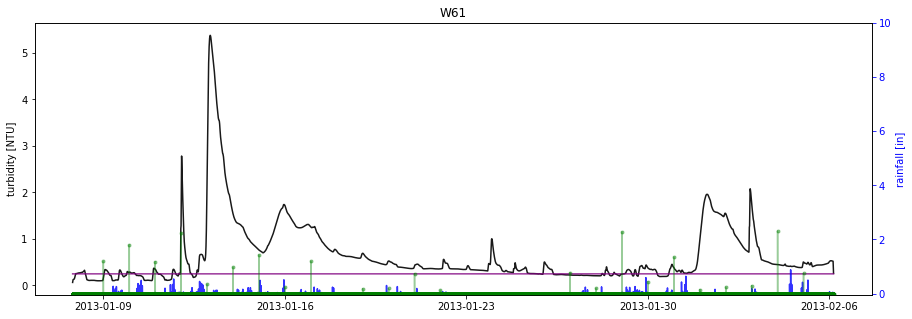

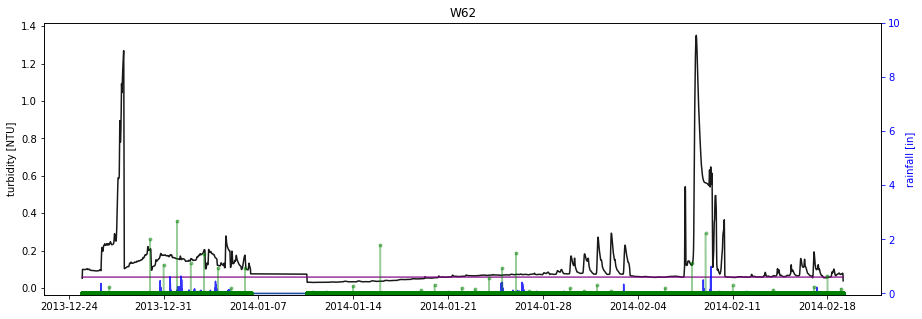

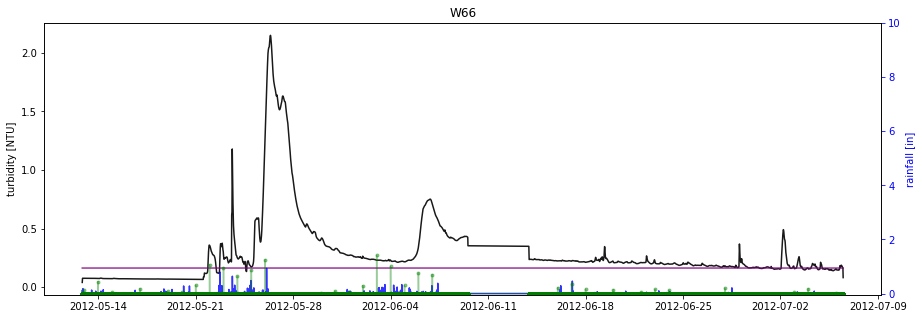

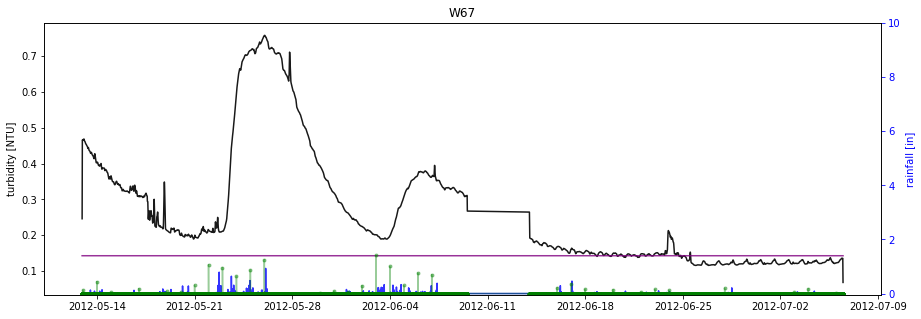

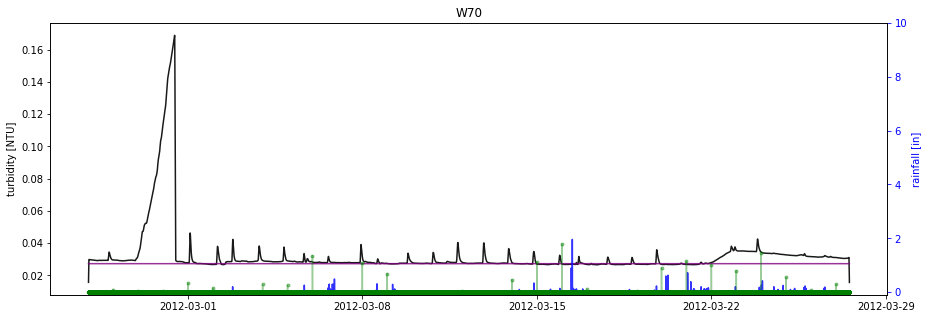

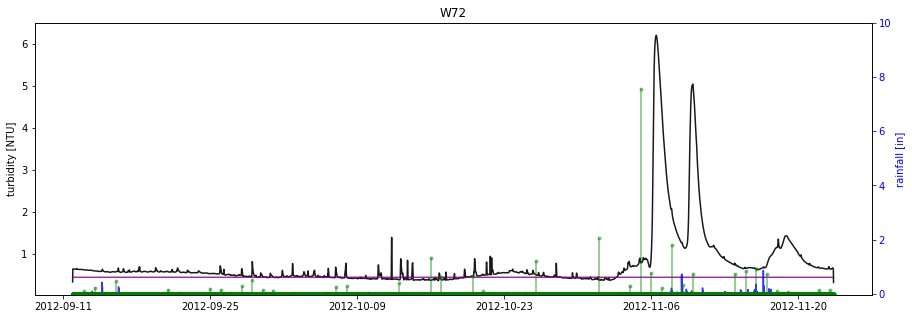

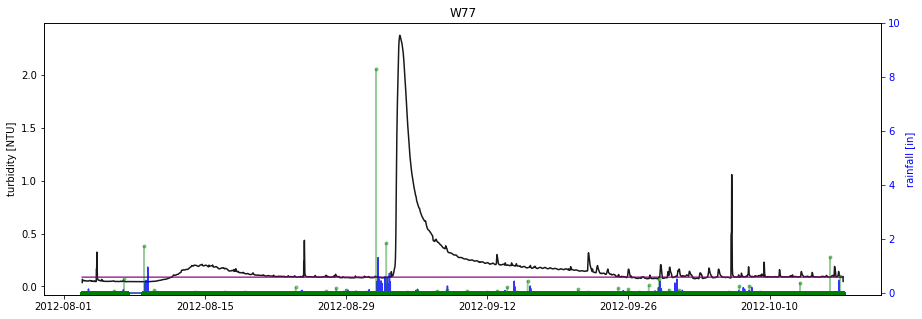

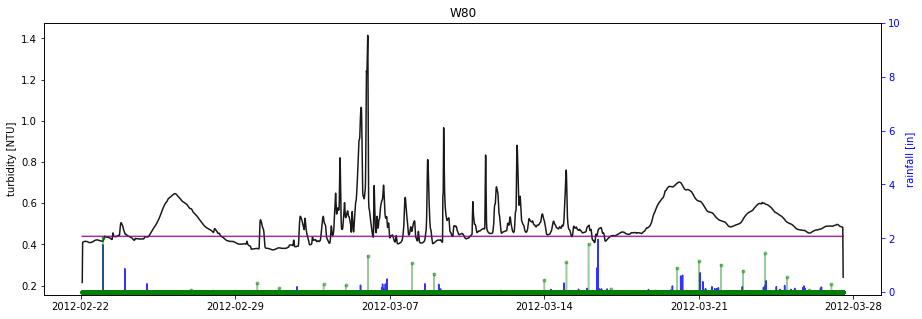

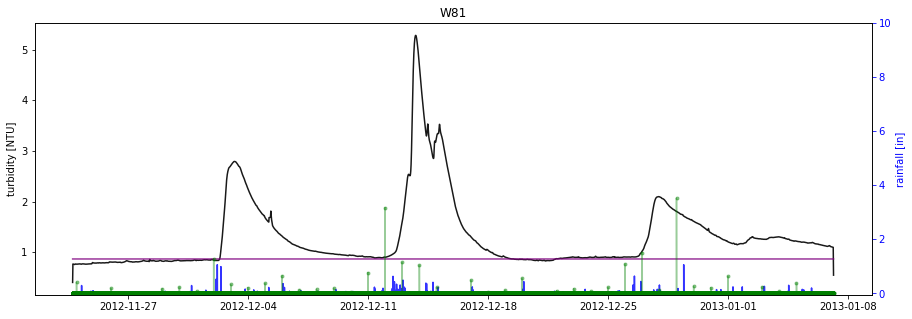

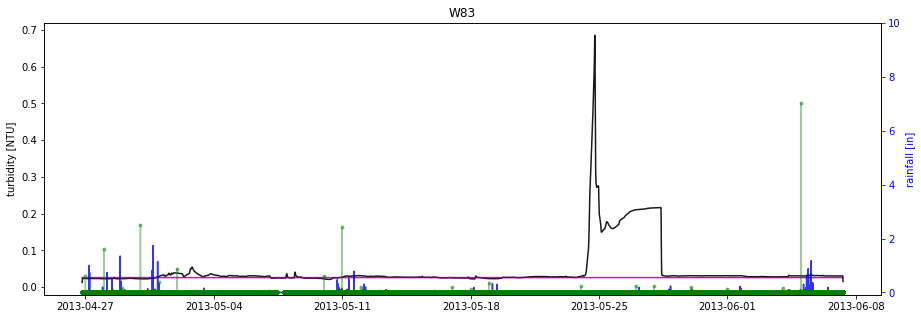

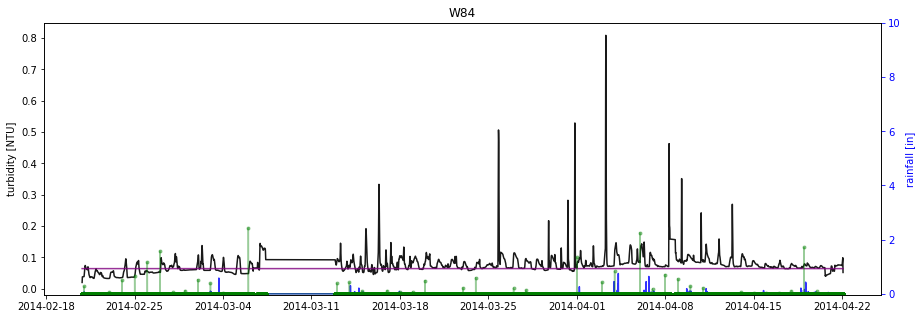

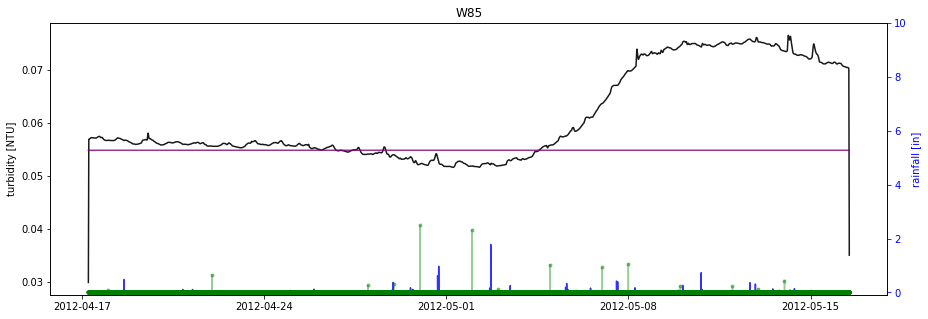

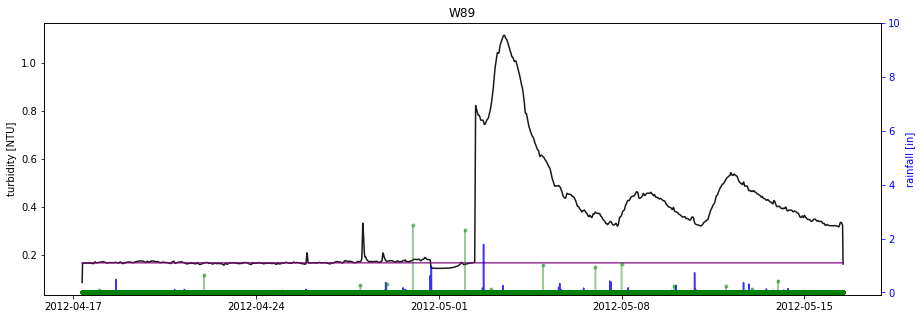

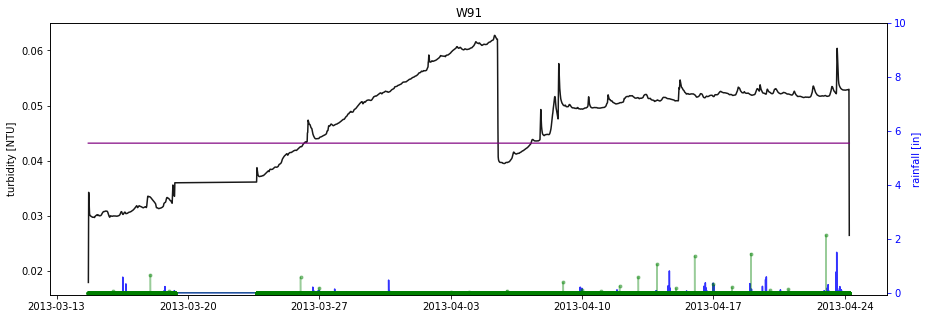

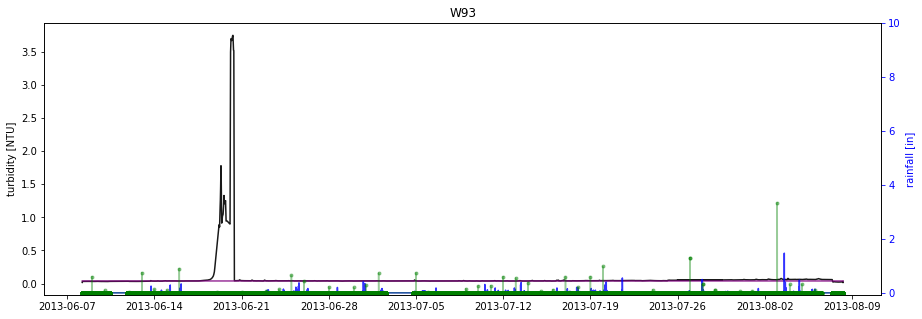

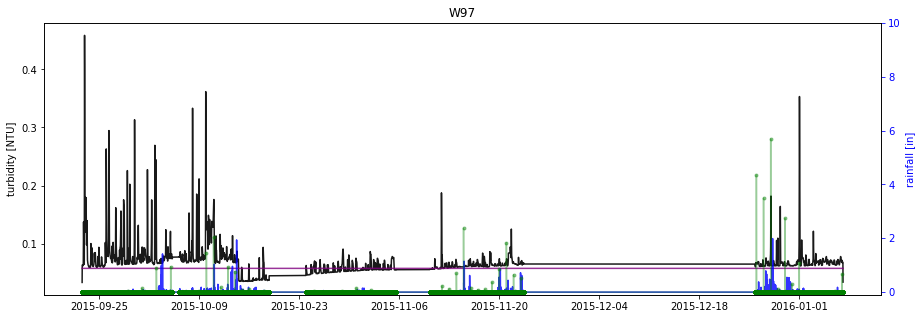

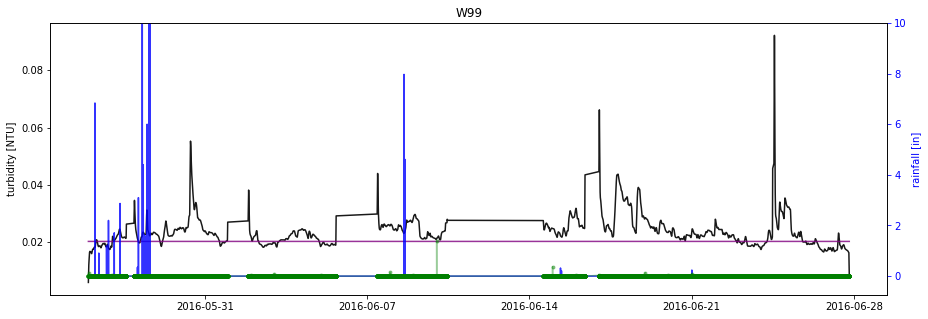

In [5]:
# another round of more advanced filtering NTU_peaksNTU_peaks
os.chdir(homedir)
os.chdir(processed)
plt.close("all")  # close previous figures to clear memory

# record length counter
record_lengths = {}

#paramaters:       # can change filtering paramaters if want or comment out extra passes of rolling median filter
med_win = 60
Gpts = 50
Gshp = .5

for i in data:
#Now for some real basic data filtering        
    data[i]['filtered_NTU'] = data[i]['NTU'].rolling(window=med_win, center=True).median()   # use rolling median filter
    data[i]['filtered_NTU2'] = data[i]['filtered_NTU'].rolling(window=med_win, center=True).median()  
    data[i]['filtered_NTU3'] = data[i]['filtered_NTU2'].rolling(window=med_win, center=True).median() 
    data[i]['filtered_NTU4'] = data[i]['filtered_NTU3'].rolling(window=med_win, center=True).median() 
    data[i]['filtered_NTU5'] = data[i]['filtered_NTU4'].rolling(window=med_win, center=True).median() 
    data[i]['filtered_NTU6'] = data[i]['filtered_NTU5'].rolling(window=med_win, center=True).median() 
    data[i]['filtered_NTU7'] = data[i]['filtered_NTU6'].rolling(window=med_win, center=True).median()
    data[i]['filtered_NTU8'] = data[i]['filtered_NTU7'].rolling(window=med_win, center=True).median()
    data[i]['filtered_NTU9'] = data[i]['filtered_NTU8'].rolling(window=med_win, center=True).median()
    data[i]['filtered_NTU10'] = data[i]['filtered_NTU9'].rolling(window=med_win, center=True).median() 
    del data[i]['filtered_NTU']
    del data[i]['filtered_NTU2']
    del data[i]['filtered_NTU3']
    del data[i]['filtered_NTU4']
    del data[i]['filtered_NTU5']
    del data[i]['filtered_NTU6']
    del data[i]['filtered_NTU7']
    del data[i]['filtered_NTU8']
    del data[i]['filtered_NTU9']
    
    data[i] = data[i].dropna(subset = ['filtered_NTU10'], axis=0, how='any') # remove entries without values after initial med pass filtering
    data[i] = data[i].reset_index(drop=True)    # reset the index to start at 0 and go to whenever
    
# more advanced gaussian curve foriert transform data filtering
    NTUs = data[i]
    NTUs = NTUs.dropna(subset = ['filtered_NTU10'], axis=0, how='any') # remove entries with messed up dates
    v = np.array(NTUs['filtered_NTU10'])
    window = signal.general_gaussian(Gpts, p=Gshp, sig=20)
    filtered = signal.fftconvolve(window, v)
    filtered = (np.average(v) / np.average(filtered)) * filtered
    filtered = np.roll(filtered, -25)
    data[i]['double_filered_NTU'] = filtered[0:len(data[i]['filtered_NTU10'])]


#Graph em all for exploration and find NTU peaks
frame_list = list(data.keys())

for i in frame_list:
    data[i]['rain'] = data[i]['rain'].fillna(0)
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.axes()
    ax1.set_ylabel('turbidity [NTU]', color='k')
    ax1.tick_params('y', colors='k')
    ax1.set_title(i)
    
    #comment this out if you want to ignore original data    
#    ax1.plot(data[i]['date'], data[i]['NTU'], linestyle='-', marker='.', color='y', alpha=.3)
    #this is the good data       
    ax1.plot(data[i]['date'], data[i]['double_filered_NTU'], linestyle='-',  color='k', alpha=.9) 
    
    # plot the baseline 
    ax1.plot(data[i]['date'], data[i]['baseline_val'], linestyle='-', color='purple', alpha=.8)
    
# now plot rainfall #  
    ax2 = ax1.twinx()
    #ax2.plot(data[i]['date'], data[i]['daily_rain'], 'b-', alpha=0.4, marker='.')
    ax2.plot(data[i]['date'], data[i]['rain'], 'b-', alpha=0.8)
    ax2.set_ylabel('rainfall [in]', color='b')
    ax2.tick_params('y', colors='b')
    ax2.set_ylim(ymax = 10)
# airport rainfall data # can comment out if want    
    ax2.plot(data[i]['date'], data[i]['PPG_Precip'], 'g-', alpha=0.4, marker='.')
    
    #print the record length
    print (data[i]['date'].iloc[-1] - data[i]['date'].iloc[0])
    record_lengths[i] = (data[i]['date'].iloc[-1] - data[i]['date'].iloc[0])
    
average_study_time = sum(list(record_lengths.values()), timedelta()) / len(list(record_lengths.values()))   # just to get the average time of the datasets

# Cell 3: peak detection routine 
this routine is finickey and thus needs to run on different datasets so that the peak detection ratio is not tiny and detects a crazy amount of peaks

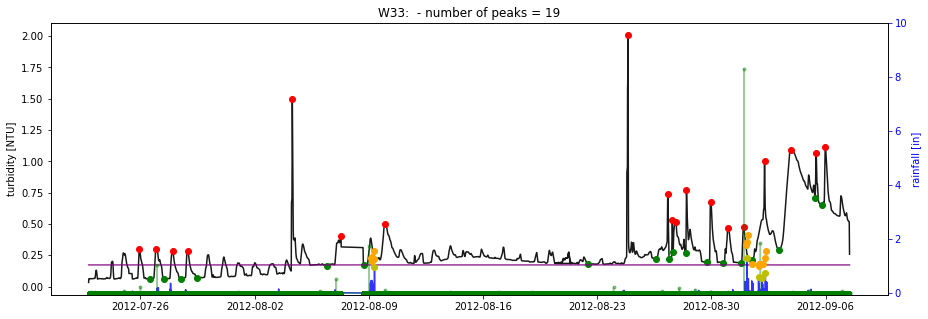

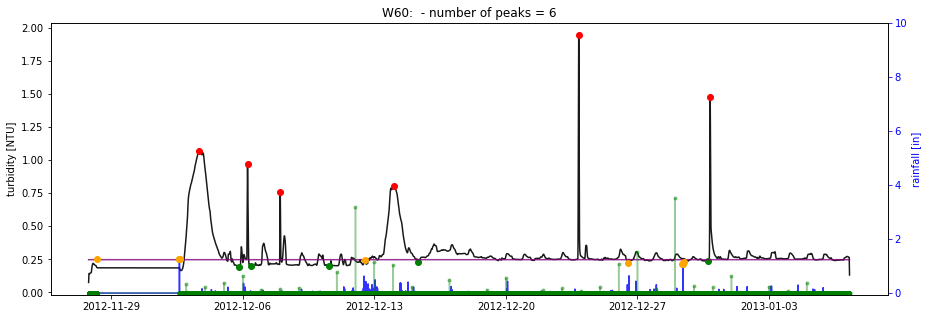

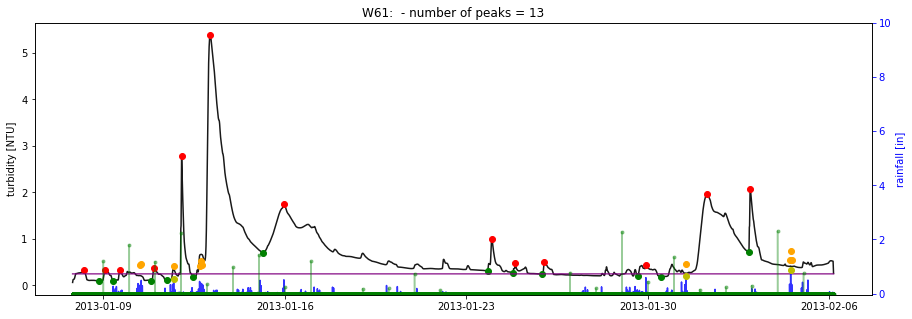

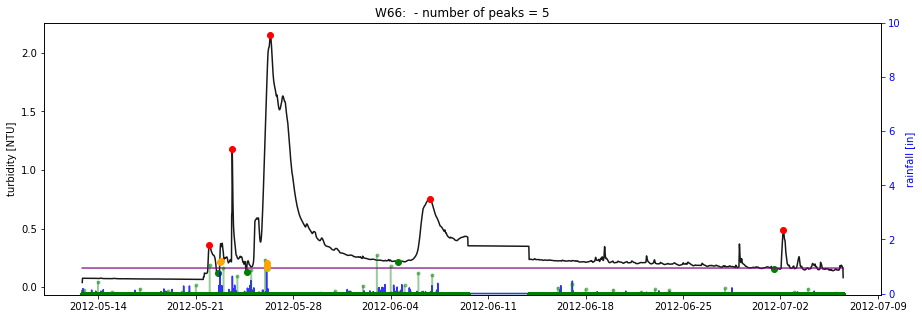

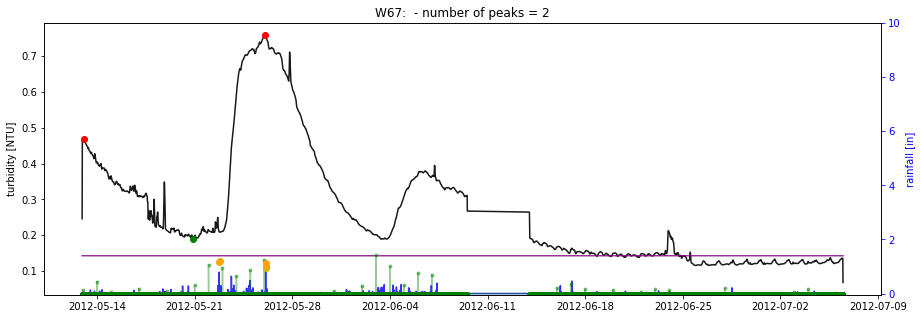

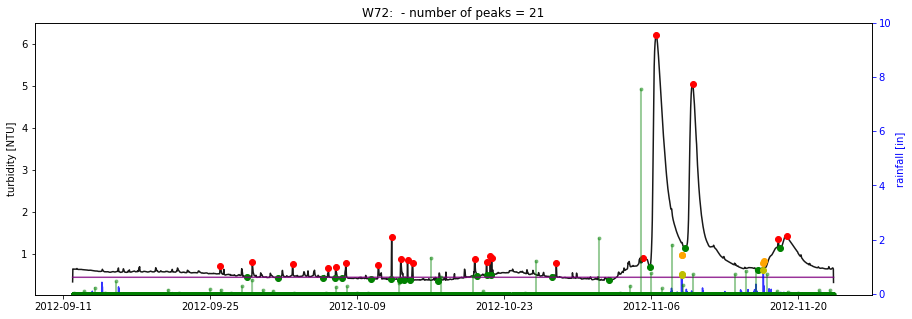

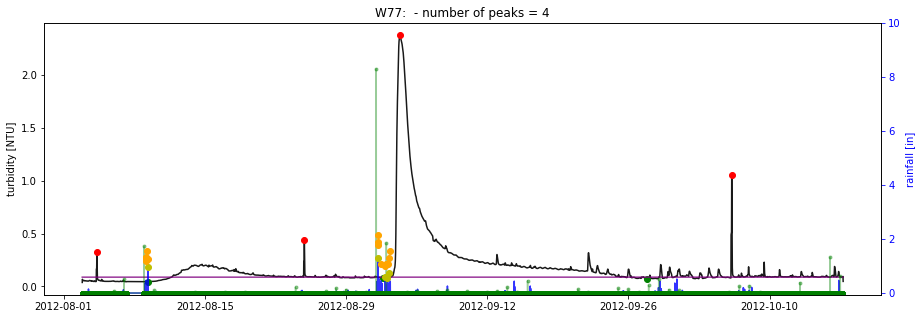

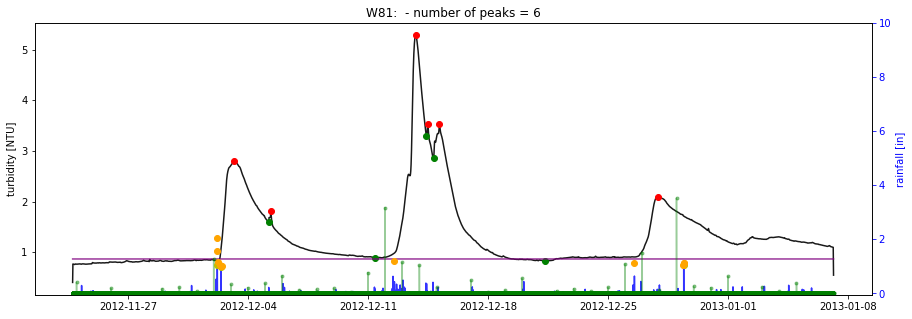

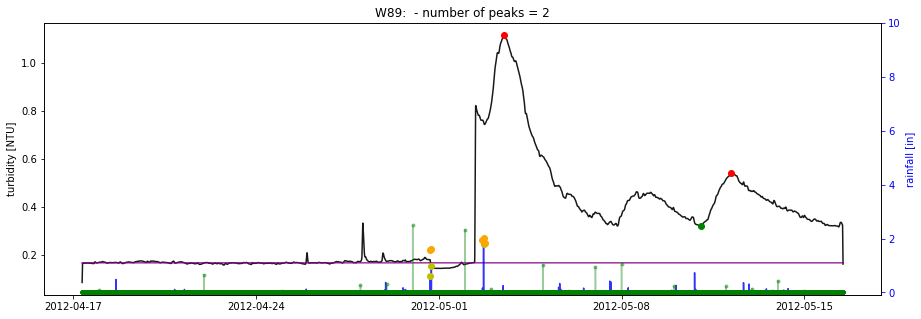

In [6]:
# peak detection routine 
plt.close("all")  # close previous figures to clear memory

# this is the sensitivity paramater of the peak finding routine, change up to dial in how it finds peaks
DeltaPeaks = .21

# The various lists of plots to include in this round, then can taylor the particular peak sensitivity to the right level for each batch. copy and paste name into the loop below and change DeltaPeaks = to the commented value

Taf_GUDI_wells = ['W33', 'W60', 'W61', 'W66', 'W67', 'W72', 'W77', 'W81', 'W89'] # use DeltaPeaks = .21
moa_wells = ['W70', 'W80','W91', 'W93', 'W119']       # use DeltaPeaks = .018
upper_moa_wells = ['W168', 'W169', 'W83']    # use DeltaPeaks = .06
upper_moa_wells_169_only = ['W169']    # use DeltaPeaks = .45
pav_wells = [ 'W171', 'W177', 'W178']  # use DeltaPeaks = .11
ili_wells = ['W84','W62','W167'] # use  DeltaPeaks = .015
aua_wells = ['W97', 'W99']        # use DeltaPeaks = .03
pago_wells = ['W101', 'W107', 'W163','W165']   # use DeltaPeaks = .18
other_wells= ['W128','W302', 'W164'] # use DeltaPeaks = .02
broken_files = ['W182']
no_spike_wells = ['W85','W183', 'W183v2', 'W172']

for i in Taf_GUDI_wells: # THIS is where you copy and past the above subset of wells name
    maxtab, mintab = peakdet(data[i]['double_filered_NTU'], DeltaPeaks)  # this is the peak finding function, use paramaters above to control
    
# these are needed to take care of arrays that are empty i.e there are no found peaks in the data
    if maxtab.size:
        maxes_x = data[i]['date'][list(array(maxtab)[:,0])] # this is a list of the date values where above function found peaks
    else: 
        maxes_x = 1
    if mintab.size:
        mins_x = data[i]['date'][list(array(mintab)[:,0])]  # this is a list of the date values where above function found velleys
    else: 
        mins_x = 1
    if mintab.size:
        maxes_y = list(array(maxtab)[:,1])   # the NTU values of the top of the peaks 
    else: 
        maxes_y = 1
    if mintab.size:
        mins_y = list(array(mintab)[:,1])    # the NTU values of the bottom of the valleys
    else: 
        mins_y = 1
    
# make the same plots as in the above cell
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.axes()
    ax1.set_ylabel('turbidity [NTU]', color='k')
    ax1.tick_params('y', colors='k')
    ax1.plot(data[i]['date'], data[i]['double_filered_NTU'], linestyle='-',  color='k', alpha=.9)       # plot the filtered turbidity values
    ax1.set_title(i+':  - ''number of peaks = ' + str(len(maxtab)))
    
#UNFILTERED data   Comment out if not want
#    ax1.plot(data[i]['date'], data[i]['NTU'], linestyle='-', marker='.', color='y', alpha=.3)
    
# plot the peak detected dots    
    plt.plot(maxes_x, maxes_y, color='r', linestyle='None', marker='o')
    plt.plot(mins_x, mins_y, color='g', linestyle='None', marker='o')     # this shows the min values (probably dont need)
# plot the baseline value too
    ax1.plot(data[i]['date'], data[i]['baseline_val'], linestyle='-', color='purple', alpha=.8)

#plot rainfall 
    ax2 = ax1.twinx()
 #   ax2.plot(data[i]['date'], data[i]['daily_rain'], 'b-', alpha=0.4, marker='.')
    ax2.plot(data[i]['date'], data[i]['rain'], 'b-', alpha=0.8)                                                 # hourly rainfall
    ax2.set_ylabel('rainfall [in]', color='b')
    ax2.tick_params('y', colors='b')
    ax2.set_ylim(ymax = 10)    # limit to the height of the rainfall graph so it is not too tall
    ax2.plot(data[i]['date'], data[i]['PPG_Precip'], 'g-', alpha=0.4, marker='.')                               # plot airport rain data
    ax2.plot(data[i]['date'], data[i]['high_rain_rate_hrly'], linestyle='None', marker='o', color='y')          # plot high rainfall event dots
    ax2.plot(data[i]['date'], data[i]['Rol_sum_3hr'], linestyle='None', marker='o', color='orange')   
    plt.show()      
    
# this block will create a data frame of the NTU peaks and valley points
    # peaks   
    peaks_y = pd.DataFrame({'NTU': maxes_y})    # put all this junk into dataframe format
    peaks_x = pd.DataFrame({'date': maxes_x})
    peaks_x = peaks_x.reset_index(drop=True)
    NTU_peaks = pd.concat([peaks_x, peaks_y ], axis=1)  # this is the dataframe of NTU peaks
    #valleys
    valleys_y = pd.DataFrame({'NTU': mins_y})    # put all this junk into dataframe format
    valleys_x = pd.DataFrame({'date': mins_x})
    valleys_x = valleys_x.reset_index(drop=True)
    NTU_valleys = pd.concat([valleys_x, valleys_y ], axis=1)  # this is the dataframe of NTU peaks
    NTU_peaks_valleys = pd.concat([NTU_peaks, NTU_valleys ], axis=0)  # stick them both together   
    
# this block defines rainfall events based on amount in particular time spans
    event = data[i]['event_occurence'] == 1             # create a dataframe of just rain peaks 
    event_rows = data[i][event]            
    rain_events_list = event_rows[['date', 'rain', 'Rol_sum_3hr', 'high_rain_rate_hrly']]   # now this is the dates of rain events  
    
# this code block will ID the baseline points that are adjacient to spikes to be used in the selection of side points for 
    spike_mean = NTU_peaks['NTU'].mean()    # find the spike in the actual data set
    norm = spike_mean*.05 + data[i]['baseline_val'][2]    # define what is normal for to return to, maybe 5% of the spike height? 
    normal_datas  = data[i]['double_filered_NTU'] <  norm    # this is a boolian of the indexes where we are at "normal"
    base_dataset = data[i][normal_datas]                     # put in boolian to select data that is elegible to be a normal turbidity time 
    base_dataset = base_dataset[['date', 'double_filered_NTU']]   # cut out unwanted columns

    temp_combo_frame = base_dataset.merge(NTU_peaks, how='outer', on='date')   #  merge the ntu peak points with allll baseline data 
    temp_combo_frame = temp_combo_frame.sort_values(by='date')                 # get the peaks in the right spot in the baseline data for indexing
    temp_combo_frame = temp_combo_frame.reset_index(drop=True)                 # indexing

    y = temp_combo_frame['NTU'].notnull()                 #select just the NTU points with their respective indexes 
    spike_list = temp_combo_frame[y].index.tolist()       # to list with indexes 

    adj_base_pts = []              # this loop will generate just the baseline points that are adjacent to the spike points
    for p in spike_list:
        b = p - 1
        c = p + 1
        adj_base_pts.append(b)
        adj_base_pts.append(c)
    just_base_pts = temp_combo_frame.iloc[adj_base_pts[1:-1]]   # if there happen to be spikes right next to eachother a value will have a NTU value, and be at the date of the top of the spike, ignore these. Also ignoring the first and last values because of error throwing...  
    just_base_pts = just_base_pts.rename(columns={'double_filered_NTU': 'baseline_pts'})  # now the baseline_pts col is the one to keep!
    del just_base_pts['NTU']
# plot the base points         
#    ax1.plot(just_base_pts['date'], just_base_pts['baseline_pts'], linestyle='None',  color='purple', alpha=.9, marker='o', label=just_base_pts['date'])     
    #plt.legend()
#    plt.show()
# this will generate the event files that contain the data to be hand selected to finally compile the      
    os.chdir(homedir)
    os.chdir(processed)
    
    events_list = rain_events_list.merge(NTU_peaks_valleys, how='outer', on= 'date' )      # merge them both together into one dataframe
    events_list = events_list.merge(just_base_pts, how='outer', on= 'date')
    events_list.to_csv(i + '_events.csv')
    
    

# Cell 4: consolidataion of event and peak data into spreadsheet
this cell reads the hand selected spikes that are in the hand processed folder 

In [7]:
#transform all the junky spike data into a dictionary of dataframes of organized spike lists 
os.chdir(homedir)
os.chdir(hand_processed)
plt.close("all")  # close previous figures to clear memory

p_files = os.listdir() # make a list of all the files in the directory

p_data = {}
for i in p_files:                                         # read files into a Dict called p_data that is basically an in-memory form of the hand processed files
    x = pd.read_csv(i)                                          # read each file
    key_name = i.split("_")[0]                                  # name it as the well #
    x['date'] = pd.to_datetime(x['date'], errors='coerce')      # string date to real date
    x = x.dropna(subset = ['date'], axis=0, how='any')          # remove entries with messed up dates
    x = x.replace(' ', '')                                      # delete any  eronious spaces in the data
    x['Rol_sum_3hr'] = x['Rol_sum_3hr'].apply(lambda y: float(y))    # make sure all rain values are of float type 
    p_data[key_name] = x                                             # make the dataframe key the first date name

s_data = {}
for h in p_data:
    s = pd.notnull(p_data[h]['NTU'])                          #select the rows with the data for the actual turbidity spike date
    spikes = p_data[h][s]
    spikes = spikes[['date','NTU']]                           #select only the date and NTU magnitude
    spikes = spikes.rename(columns={'date': 'spike_date'})
    spikes = spikes.reset_index(drop=True)

    r = pd.notnull(p_data[h]['Rol_sum_3hr'])                  # select the rows with the data for the rainfall events, and specifically the 3hr rolling sum (the 1 hour total always had a strong 3 hr sum also)
    rains = p_data[h][r]
    rains = rains[['date', 'Rol_sum_3hr']]
    rains = rains.rename(columns={'date': 'rain_date'})
    rains = rains.reset_index(drop=True)
    
    b = pd.notnull(p_data[h]['baseline_pts'])                #select the rows with the start or end of the turbidity spike
    bases = p_data[h][b]
    bases = bases.reset_index(drop=True)
    starts = []
    starts_date = []
    ends = []
    ends_date =[]
    for l in list(bases.index):                              #in the hand processed data a start always comes before an end, this it will be indexed as am odd #
        if (l % 2 == 0):                     #the little % is the 'what is the remainder operator and will spit a 1 if the L number is odd and a 0 if it is even
            starts.append(bases.iloc[l]['baseline_pts'])
            starts_date.append(bases.iloc[l]['date'])
        if (l % 2 != 0):                                    #and an end alwyas is after a start, this it will be indexed as am even #
            ends.append(bases.iloc[l]['baseline_pts']) 
            ends_date.append(bases.iloc[l]['date']) 
    start = pd.Series(starts, name='starts_NTU')
    start_date = pd.Series(starts_date, name='start_date')
    end = pd.Series(ends, name='ends_NTU')
    end_date = pd.Series(ends_date, name='end_date')        # by using their positions as odds and evens the starts and ends are selected out from the combined data

    
    spike_events = pd.concat([rains, spikes,start_date, start,end_date, end], axis=1)         # put all the date from each event onto one row
    spike_events['lenth_of_spike'] = spike_events['end_date'] - spike_events['start_date'] 
    spike_events['response_to_start'] = spike_events['start_date'] - spike_events['rain_date']
    spike_events['response_to_peak'] = spike_events['spike_date'] - spike_events['rain_date']      #calculate some statistics for each event
        
    s_key = h +'_spikes' 
    s_data[s_key] =  spike_events                          # this is now the dictionary of the spike event data


# in order to get each well as a separate row in a csv file...   
lenth_of_spike_ave = []            
response_to_start_ave = []
response_to_peak_ave =[]
n = []
max_NTU =[]
Well_nam = []
    
  
for j in s_data.keys():
    name = j.split("_")[0]      # name it as the well #
    lenth_of_spike_ave.append(s_data[j]['lenth_of_spike'].mean().seconds/3600 + s_data[j]['lenth_of_spike'].mean().days*24)
    response_to_start_ave.append( s_data[j]['response_to_start'].mean().seconds/3600    +   s_data[j]['response_to_start'].mean().days*24)
    response_to_peak_ave.append(s_data[j]['response_to_peak'].mean().seconds/3600 + s_data[j]['response_to_peak'].mean().days*24)
    n.append(s_data[j]['lenth_of_spike'].count())
    max_NTU.append(s_data[j]['NTU'].max())
    Well_nam.append(j.split('_')[0])

# this is the dataframe that will turn to csv
spike_stats = pd.DataFrame({'Well':Well_nam, 'lenth_of_spike[hrs.]':lenth_of_spike_ave, 'response_to_start[hrs.]':response_to_start_ave, 'response_to_peak[hrs.]':response_to_peak_ave,'max_NTU':max_NTU, 'n':n})
    
    
os.chdir(homedir)
spike_stats.to_csv('spike_stats.csv')    # go to CSV

# Cell 5: Nice plots of GUDI wells or wells with spikes


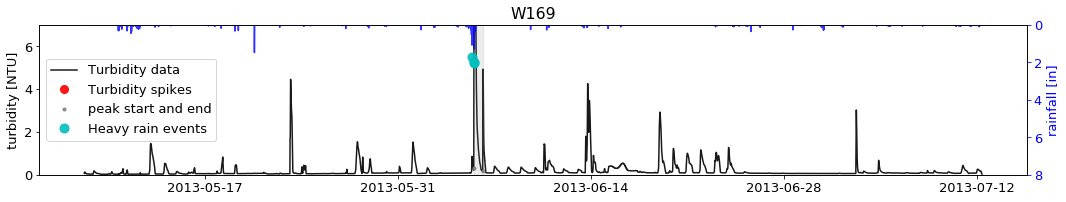

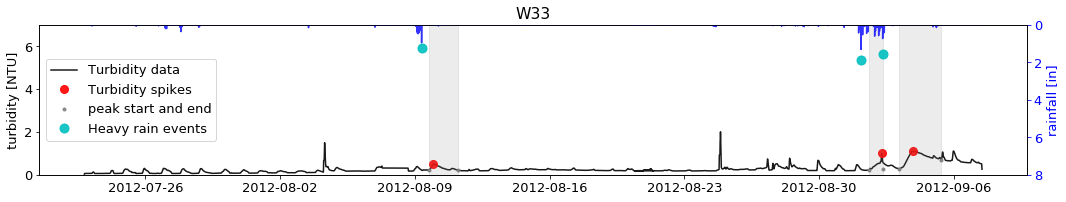

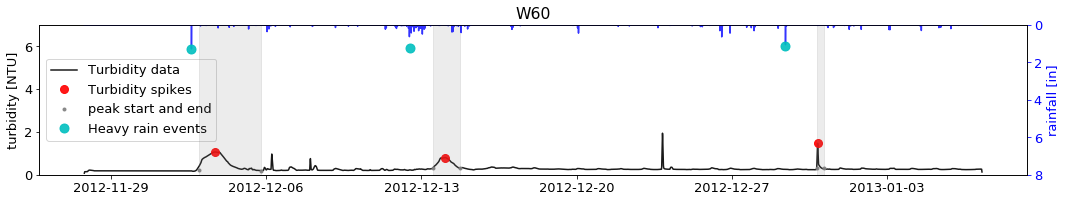

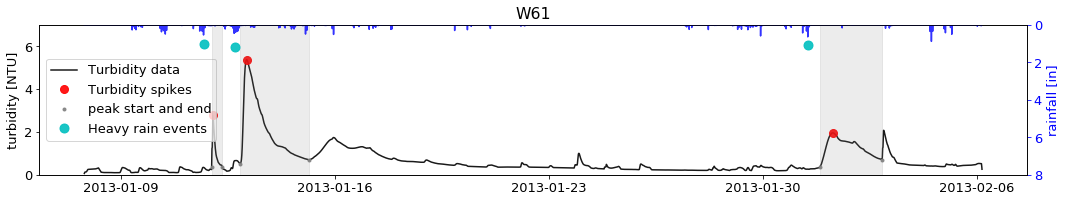

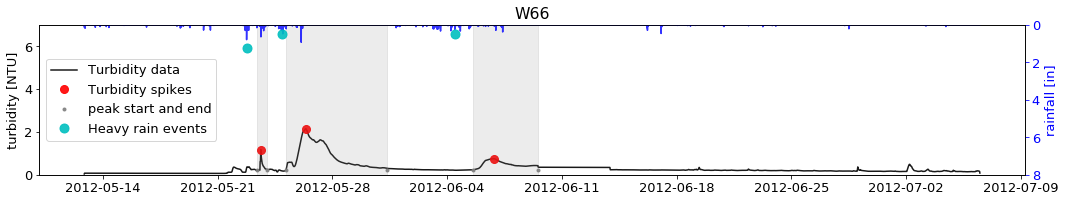

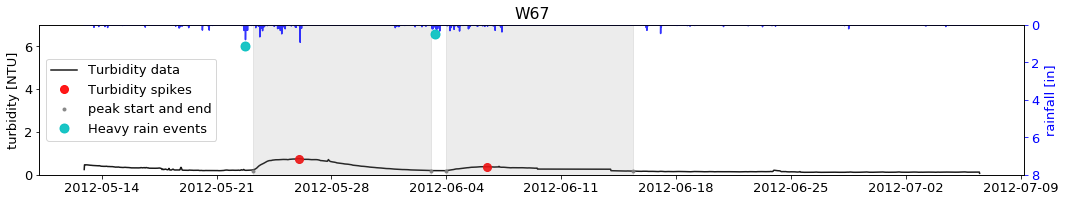

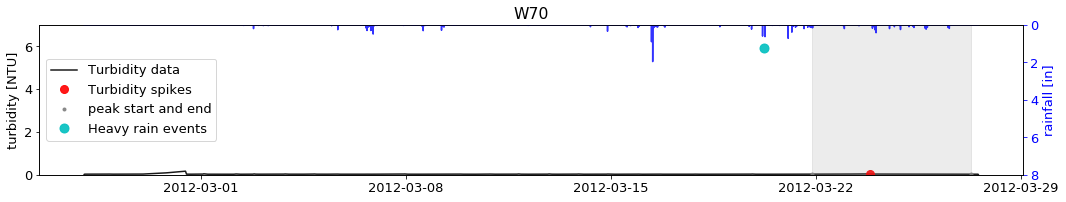

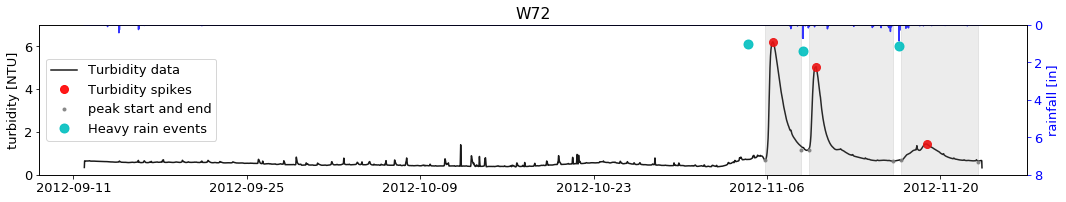

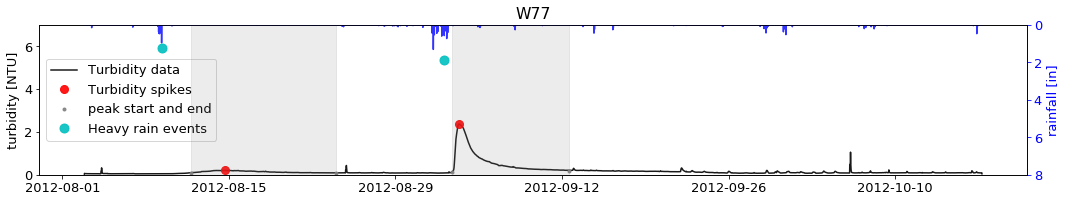

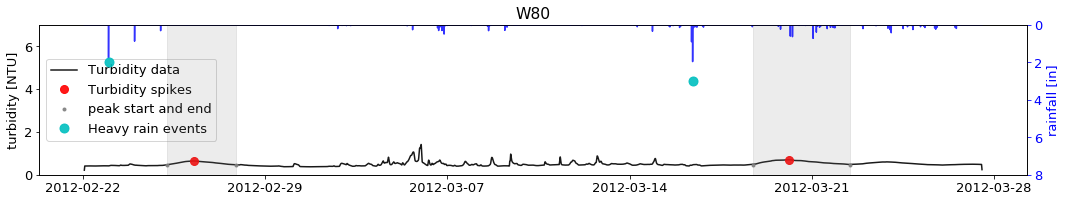

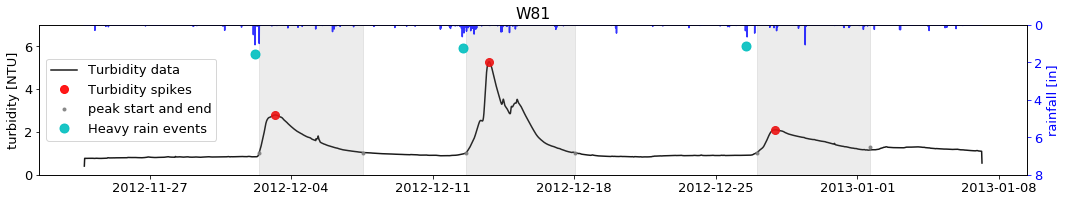

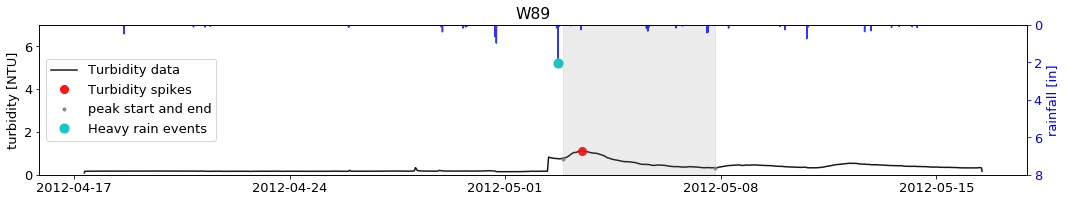

In [8]:
# final plots of data with spikes
plt.close("all")  # close previous figures to clear memory
os.chdir(homedir)

for i in list(spike_stats['Well']):  
    os.chdir(homedir)
    os.chdir(hand_processed)
    
#plot base NTU data
    fig = plt.figure(figsize=(15, 3))
    plt.rcParams.update({'font.size': 13})    
    ax1 = plt.axes()
    ax1.set_ylabel('turbidity [NTU]', color='k')
    ax1.tick_params('y', colors='k')
    
    #comment this out if you want to ignore original data    
#    ax1.plot(data[i]['date'], data[i]['filtered_NTU'], linestyle='-', marker='.', color='white', alpha=.2, label='')  # seems to not work.... not sure why
    #this is the good data       
    ax1.plot(data[i]['date'], data[i]['double_filered_NTU'], linestyle='-',  color='k', alpha=.9, label='Turbidity data') 
 #   ax1.set_title(i+':  - ''number of peaks = ' + str(len(maxtab)))
 #   ax1.set_ylim(0,(data[i]['double_filered_NTU'].max()+data[i]['double_filered_NTU'].max()*.3))                        # this autoscales the top of the graph
    ax1.set_ylim(0, 7)                                                                                                   # no auto scaling 
                 
# now plot rainfall #  
    ax2 = ax1.twinx()
#    ax2.plot(data[i]['date'], data[i]['daily_rain'], 'b-', alpha=0.4, marker='.')
#    ax2.plot(data[i]['date'], data[i]['PPG_Precip'], 'g-', alpha=0.4, marker='.')
    ax2.plot(data[i]['date'], data[i]['rain'], 'b-', alpha=0.8, label='')
    ax2.set_ylabel('rainfall [in]', color='b')
    ax2.tick_params('y', colors='b')
    ax2.set_ylim(8,0)                                # control the rainfall axis height (putting the max value first inverts it!)
    
# put the event and peak dots on the plots    
    dots = pd.read_csv(i+'_hand_processed.csv')
    dots = dots.dropna(subset = ['date'], axis=0, how='any')
    dots['date'] = pd.to_datetime(dots['date'], errors='coerce')
      
    ax1.plot(dots['date'], dots['NTU'], linestyle='None',  color='r', alpha=.9, marker='o', label='Turbidity spikes', markersize=8) # plot the peaks 
    
    ax2.plot(dots['date'], dots['Rol_sum_3hr'], linestyle='None',  color='c', alpha=.9, marker='o', label='Heavy rain events ', markersize=9)     # plot the rainfall 
    
    ax1.plot(dots['date'], dots['baseline_pts'], linestyle='None',  color='grey', alpha=.9, marker='.', label='peak start and end') # plot the baseline pts/ boundaries of peaks 
    
# this block puts on shaded rectangles deliniating the start and end of each peak    
    t = dots['baseline_pts'].notnull()
    boundary_pts = dots[t]
    boundary_pts = boundary_pts.reset_index(drop=True)
    for v in list(boundary_pts.index):
        if (v % 2 == 0):                  # select the even index values these should always be the start of a peak
            startTime = pd.to_datetime(boundary_pts['date'][v], errors='coerce')
                
        if (v % 2 != 0):                  # select the odd values these should always be the end of a peak
            endTime = pd.to_datetime(boundary_pts['date'][v], errors='coerce')
                    
            start = mdates.date2num(startTime)   # these are to convert the date axis to something rectangle understands
            end = mdates.date2num(endTime)
            width = end - start                  
            rect = Rectangle((start, 0), width, 10, color='grey', alpha=.15)   # draw rectangle from start and make it width of 'width', a height of 10" of rain,  
            ax2.add_patch(rect)
        
    # legend combination and handling 
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=6)
    plt.title(i)
    plt.tight_layout()
    
    os.chdir(homedir)
    os.chdir(path_printed_plots)
    fig.savefig(i + '_.pdf')

# Cell 6: Nice plots of GUDI wells or without spikes

C:\Users\cshuler\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


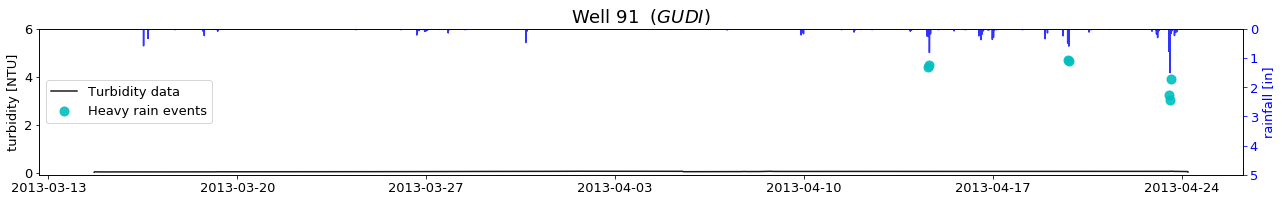

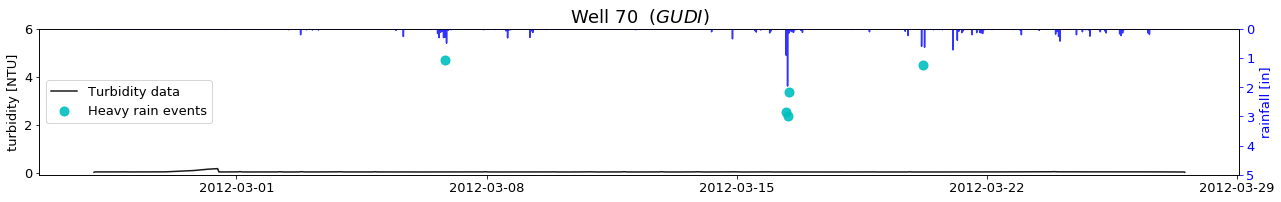

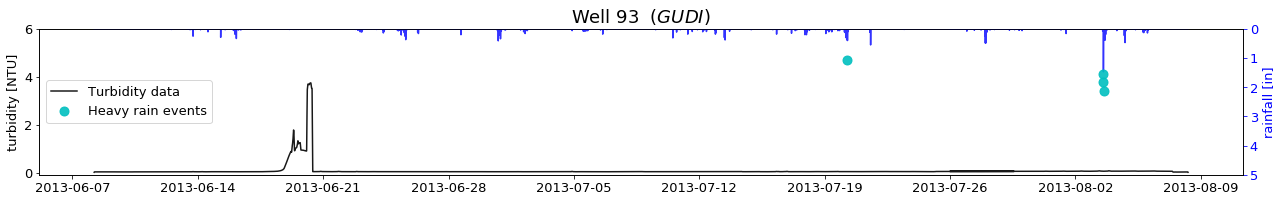

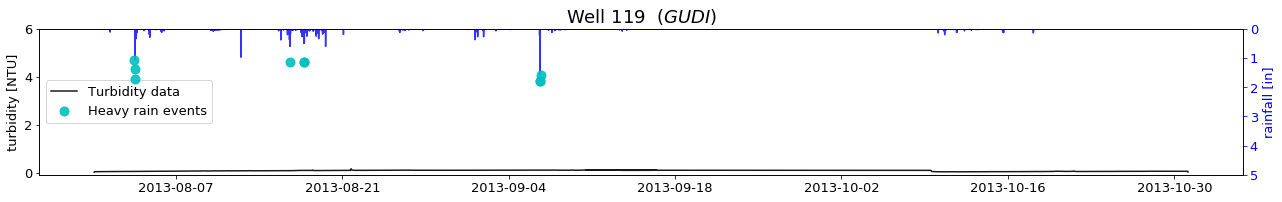

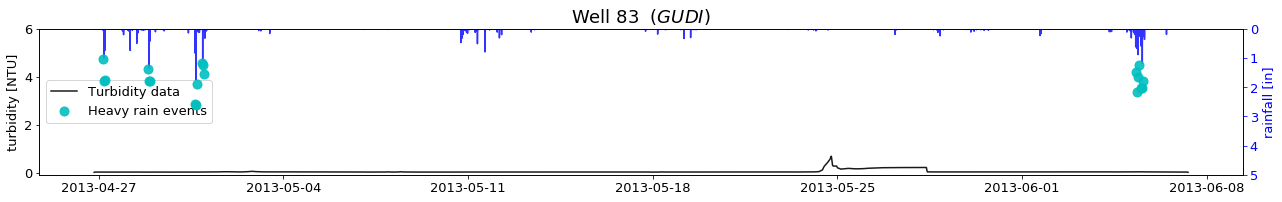

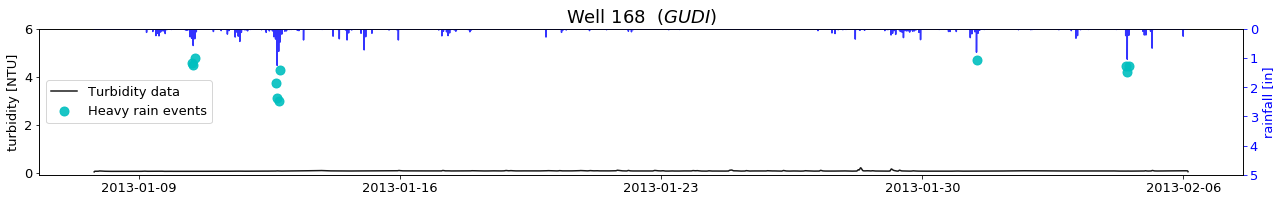

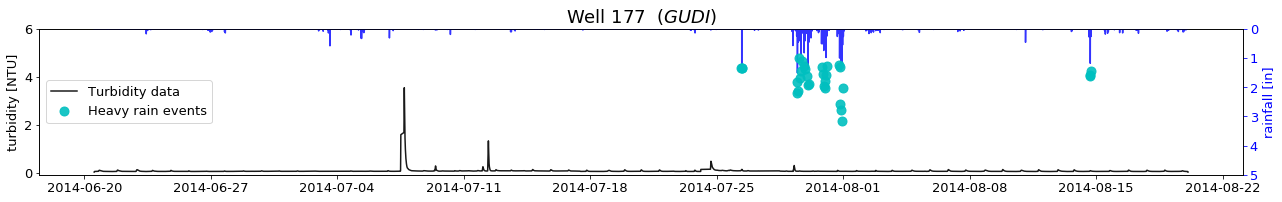

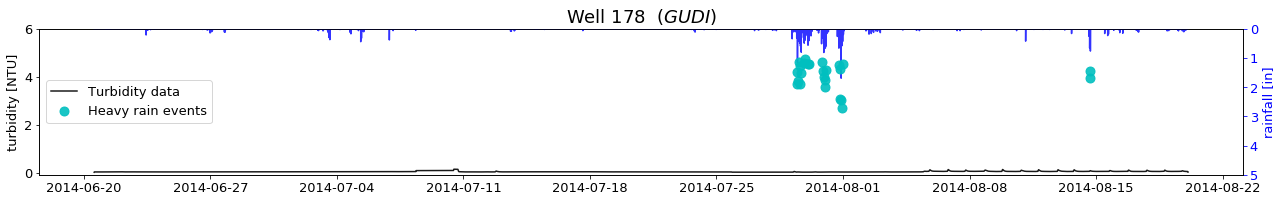

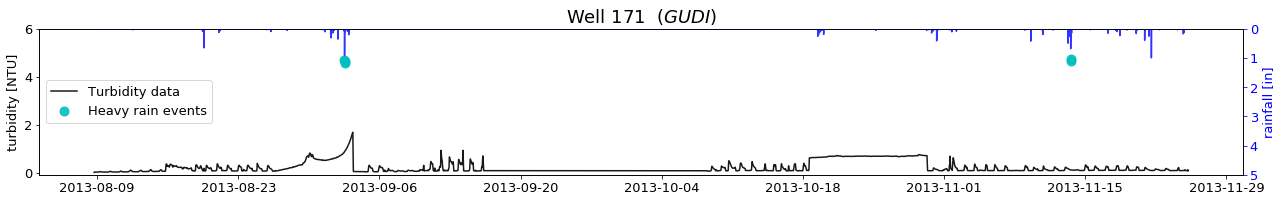

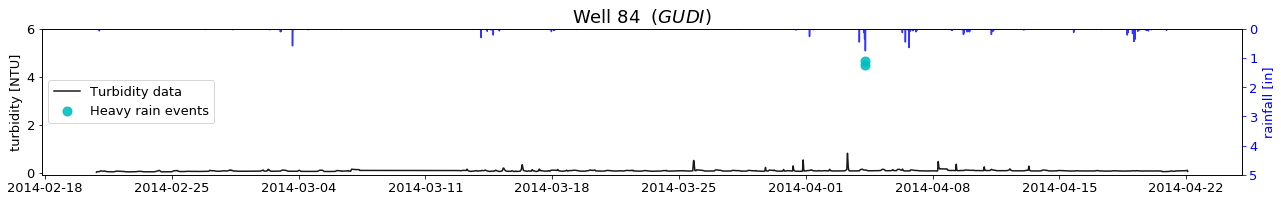

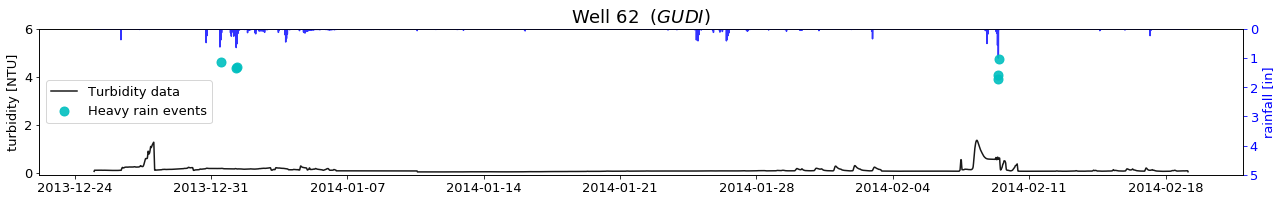

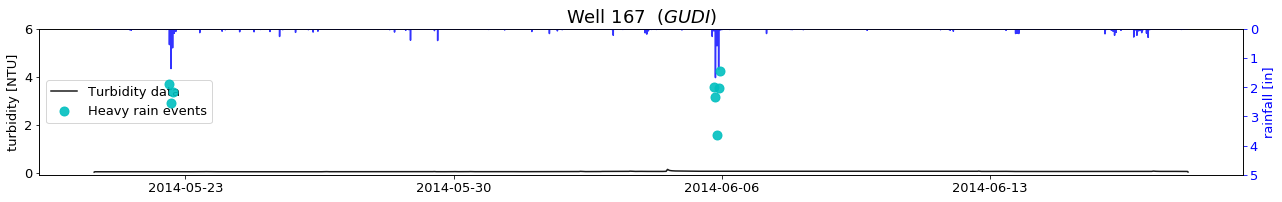

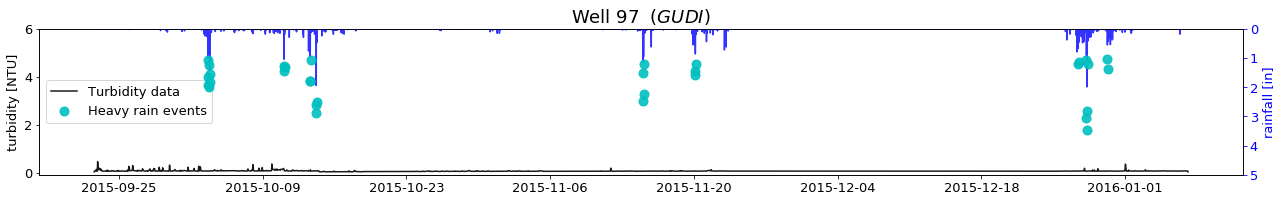

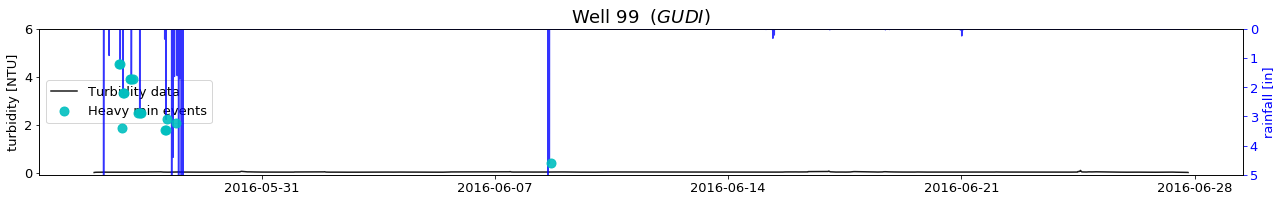

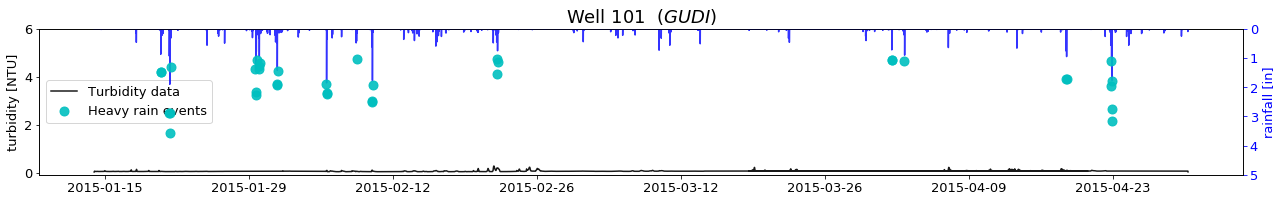

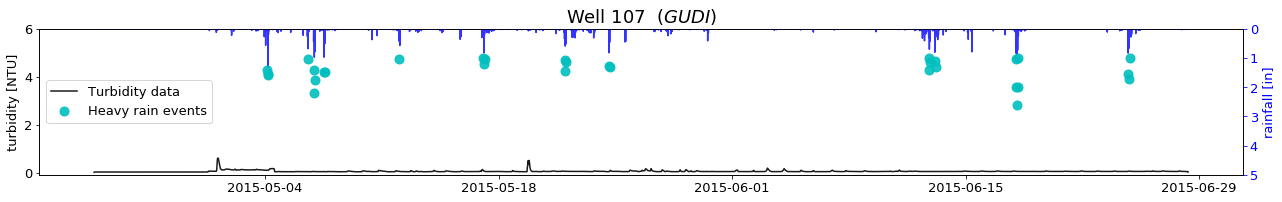

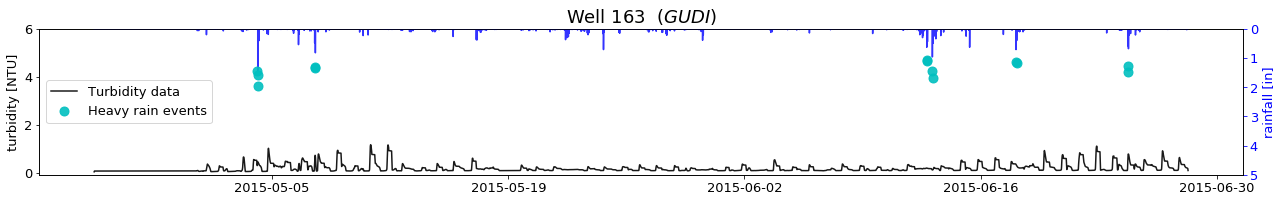

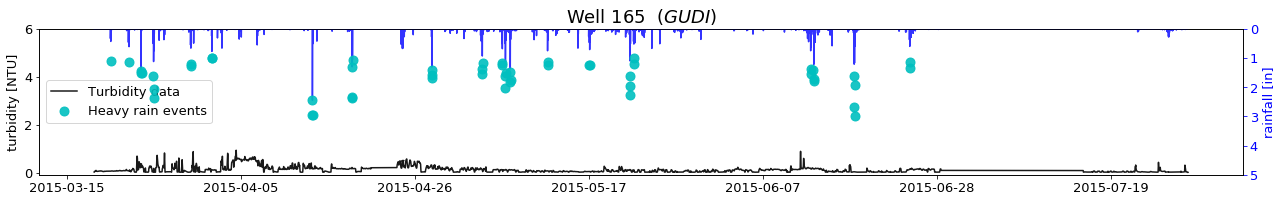

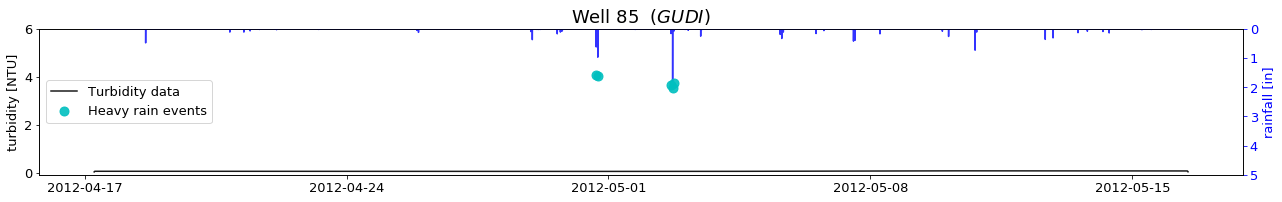

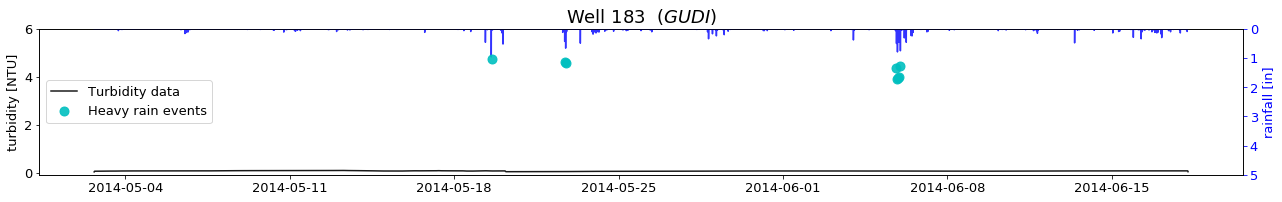

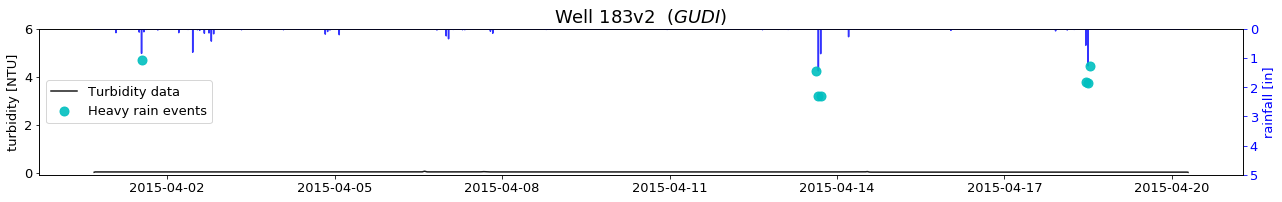

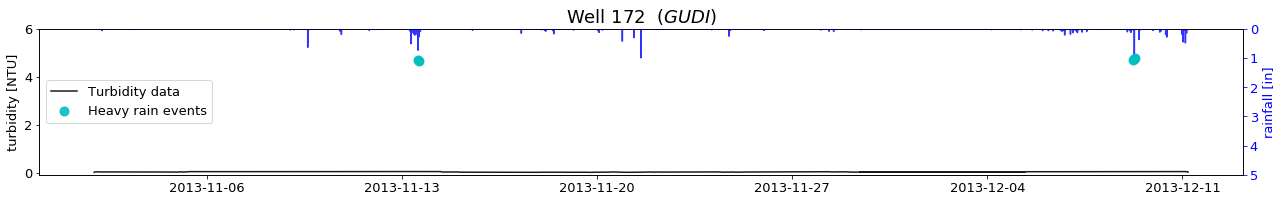

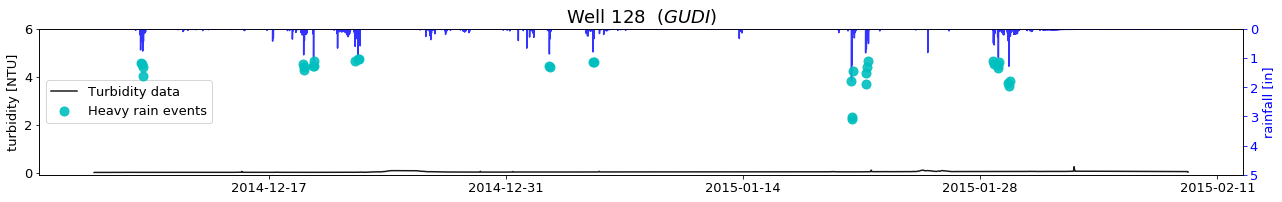

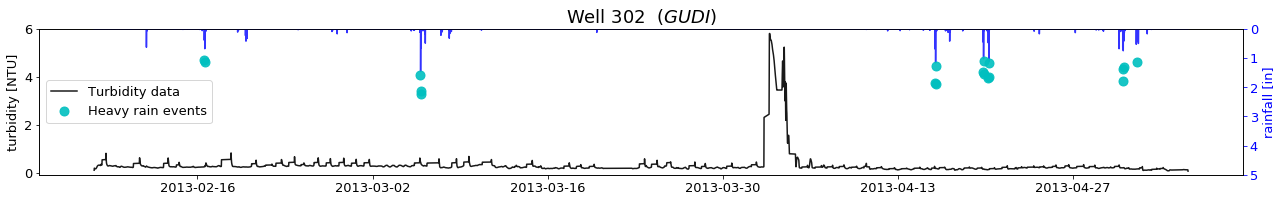

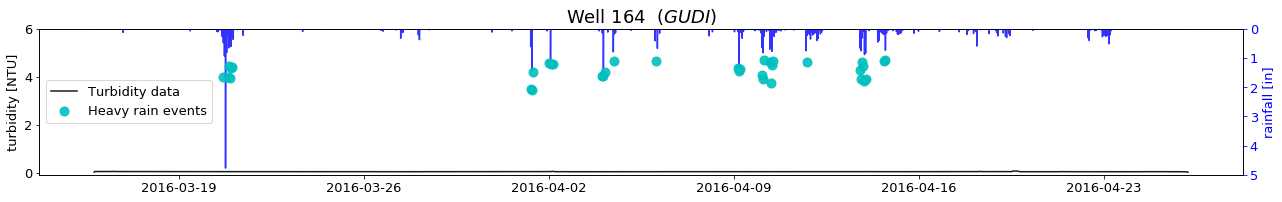

In [9]:
#Plot the wells without spikes
plt.close("all")  # close previous figures to clear memory

#define which wells are thought to have no spikes
no_spikes = ['W91', 'W70', 'W93', 'W119', 'W83', 'W168', 'W177', 'W178', 'W171', 'W84','W62','W167', 'W97', 'W99', 'W101', 'W107', 'W163','W165', 'W85','W183', 'W183v2', 'W172', 'W128','W302', 'W164']


for i in no_spikes:
#plot base NTU data
    fig = plt.figure(figsize=(18, 3))
    plt.rcParams.update({'font.size': 13})
    
    ax1 = plt.axes()
    ax1.set_ylabel('turbidity [NTU]', color='k')
    ax1.tick_params('y', colors='k')
    
    #comment this out if you want to ignore original data    
#    ax1.plot(data[i]['date'], data[i]['filtered_NTU'], linestyle='-', marker='.', color='white', alpha=.2, label='')
    #this is the good data       
    ax1.plot(data[i]['date'], data[i]['double_filered_NTU'], linestyle='-',  color='k', alpha=.9, label='Turbidity data') 
 #   ax1.set_title(i+':  - ''number of peaks = ' + str(len(maxtab)))
    ax1.set_ylim(ymax = 6, ymin = -.09)
    
# now plot rainfall #  
    ax2 = ax1.twinx()
  # ax2.plot(data[i]['date'], data[i]['daily_rain'], 'b-', alpha=0.4, marker='.')
  # ax2.plot(data[i]['date'], data[i]['PPG_Precip'], 'g-', alpha=0.4, marker='.')
    ax2.plot(data[i]['date'], data[i]['rain'], 'b-', alpha=0.8, label='')
    ax2.set_ylabel('rainfall [in]', color='b')
    ax2.tick_params('y', colors='b')
    ax2.set_ylim(5,0)
   
    #ax2.plot(data[i]['date'], data[i]['high_rain_rate_hrly'], linestyle='None', marker='o', color='y')          # plot high rainfall event dots
    ax2.plot(data[i]['date'], data[i]['Rol_sum_3hr'], linestyle='None', label='Heavy rain events',color='c', alpha=.9, marker='o', markersize=9)    
    
    

    
    
# for frustrating legend positioning
    #import time
   # from datetime import datetime
    #p = int(time.mktime(data[i]['date'][90].timetuple()))
        
# legend combination and handling 
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=6)      
    
    plt.title('Well '+i.replace("W", "")+ "  ($GUDI)$", fontsize=18)
    plt.tight_layout()    
  
    os.chdir(homedir)
    os.chdir(path_printed_plots)
    #fig.savefig(i + '_.pdf')

# This is the Ecoli part 

In [10]:
# read in the rainfall data

os.chdir(homedir)
os.chdir(path_raw_ecoli_data)


rainfall = pd.read_csv('Airport_rain.csv')

# housekeeping
rainfall['Precipitation']  = rainfall['Precipitation'].replace(' T', '.001')           # any trace rain is small
rainfall['Precipitation'] = pd.to_numeric(rainfall['Precipitation'], errors="coerce")  # any other non numbers are now NAN
rainfall['Precipitation'] = rainfall['Precipitation'].fillna(0.0)   # any NA values need to be numeric 
rainfall = rainfall.dropna(subset = ['Precipitation'], axis=0, how='any') # remove entries without precip values, meaning there was a missing point or something
rainfall['Precipitation'] = rainfall['Precipitation'].apply(lambda y: float(y))    # make sure all rain values are of float type 
rainfall['Date'] = pd.to_datetime(rainfall['Date'], errors='coerce')   # make the dates ddates


In [11]:
# read in ASPA ecoli data
os.chdir(homedir)
os.chdir(path_raw_ecoli_data)

ASPA_ecoli = pd.read_csv('Ecoli_from_EPA.csv')

# housekeeping
ASPA_ecoli['TC_count'] = ASPA_ecoli['TC_count'].str.strip('>')    # this actually removes the bad symbols from the data.  not sure why .replace does not work 
ASPA_ecoli['EC_count'] = ASPA_ecoli['EC_count'].str.strip('>')
ASPA_ecoli['TC_count'] = ASPA_ecoli['TC_count'].apply(lambda y: float(y))    # make sure all  values are of float type 
ASPA_ecoli['EC_count'] = ASPA_ecoli['EC_count'].apply(lambda y: float(y))    # make sure all  values are of float type 
ASPA_ecoli['Turbidity'] = pd.to_numeric(ASPA_ecoli['Turbidity'], errors="coerce")                                  # take out all the random crap from these columns 
ASPA_ecoli['Last 24 hours of rainfall'] = pd.to_numeric(ASPA_ecoli['Last 24 hours of rainfall'], errors="coerce")  # take out all the random crap from these columns 

ASPA_ecoli['Date_and_time'] = ASPA_ecoli['Date'] +" "+ ASPA_ecoli['Not_dumb_time']    #combine date and time  to date time, but...
ASPA_ecoli['Date'] = pd.to_datetime(ASPA_ecoli['Date'], errors='coerce')              # leave just dates to match up to rainfall

del ASPA_ecoli['Not_dumb_time']                        # delete eronius columns
ASPA_ecoli['Date_and_time'] = pd.to_datetime(ASPA_ecoli['Date_and_time'], errors='coerce')   # make the dates ddates

# note theere was a value for Well 77   that was out of the range of the other data it was
#  11/15/2012	0.349	>200.5	17.8	N/A	11:15	W77
# but I deleted the 17.8


In [12]:
# merge in pertanant rainfall amounts from the airport data 

ASPA_ecoli_data = rainfall.merge(ASPA_ecoli, how='inner', on='Date')                                     # stick on airport rainfall values for sample dates
ASPA_ecoli_data = ASPA_ecoli_data.rename(columns = {'Precipitation':'this_days_precip'})                 # rename stuff 
ASPA_ecoli_data = ASPA_ecoli_data.rename(columns = {'Last 24 hours of rainfall':'Jason24hr_rain'})

# this loop will calculate the last 48 hours of rainfall and stick that on as seperate column
precip_48hrs = []
for i in ASPA_ecoli_data['Date']:
    i = pd.to_datetime(i, errors='coerce')   # make the dates dates
    j = i- timedelta(days=1)                 # get the date of yesterday
    hrs48pcip = rainfall[rainfall['Date'] == j]['Precipitation'].iloc[0]+rainfall[rainfall['Date'] == i]['Precipitation'].iloc[0]  # tally up today and yesterdays rainfall
    precip_48hrs.append(hrs48pcip)           # make a list of the 48 hr totals  

Pcip48_df = pd.DataFrame({"48hr_rain_total":precip_48hrs})          # make that list a dataframe
ASPA_ecoli_rain = pd.concat([ASPA_ecoli_data, Pcip48_df], axis=1)   # stick the dataframe onto a new dataframe of all the ecoli values and rain


C:\Users\cshuler\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\cshuler\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\cshuler\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


39.220364741641355
0.0
200.5
0.0


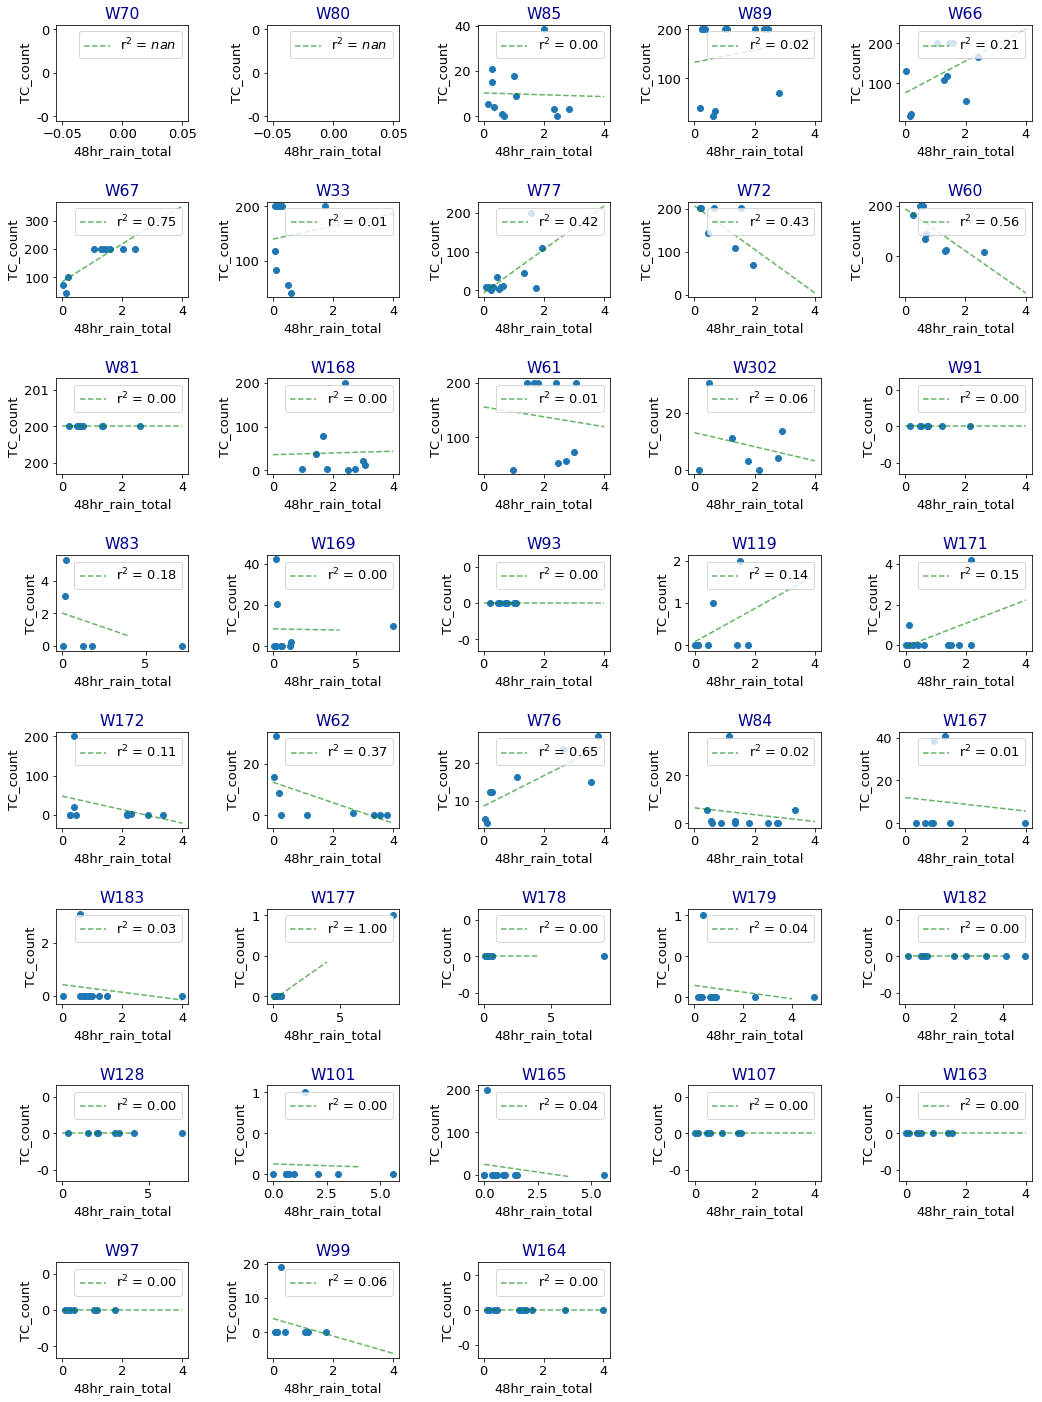

In [13]:
# put well files into individual frames and plot some variables 

plt.close("all")  # close previous figures to clear memory

by_well_ecoli_data = {}   # this is the dic of each well separated into a separate frame
sampled_wells = list(ASPA_ecoli_rain.Well.unique())   # the list of the wells sampled

# use this block to control what wells get plotted
# sampled_wells = ['W70', 'W80', 'W85', 'W89', 'W66', 'W67', 'W33', 'W77', 'W72', 'W60', 'W81', 'W168', 'W61', 'W302', 'W91', 'W83', 'W169', 'W93', 'W119', 'W171', 'W172', 'W62', 'W76', 'W84', 'W167', 'W183', 'W177', 'W178', 'W179', 'W182', 'W128','W101', 'W165', 'W107', 'W163', 'W97', 'W99','W164']   # woah
#sampled_wells = [ 'W66', 'W33', 'W77', 'W72', 'W60', 'W81', 'W61',  'W67', 'W89']   # gudi wells
#sampled_wells = ['W70', 'W80', 'W85', 'W168',  'W91', 'W83', 'W169', 'W93', 'W119', 'W171', 'W172', 'W62', 'W76', 'W84', 'W167', 'W177', 'W178' ]   # non-gudi
    

# list of values to choose from  (Date, this_days_precip, Turbidity, TC_count,  EC_count, Jason24hr_rain, Well, Date_and_time, 48hr_rain_total )
rain_value = '48hr_rain_total'
bug_value = 'TC_count'

fig = plt.figure(figsize=(15, 20))
p = 0
# this will pop apart the main data file into individual well dataframes
for i in sampled_wells: 
    working_set  = ASPA_ecoli_rain[ASPA_ecoli_rain['Well'] == i]
    by_well_ecoli_data[i] = working_set
    

for i in sampled_wells: 
    p = p+1 #iterator
    ax1 = fig.add_subplot(8,5,p)
   
    ax1.set_xlabel(rain_value, color='k')     # if you want labels on each subplot, I dont
    ax1.set_ylabel(bug_value, color='k')
    ax1.set_title(i, color='darkblue')
    
    xval = by_well_ecoli_data[i][rain_value]                 # just values for easy plug and play
    yval = by_well_ecoli_data[i][bug_value]
    
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))   # get rid of stupid non-integer axis ticks
    
    plt.scatter(xval, yval, label='', marker='o')  # plot of the ecoli data
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xval, yval)   # calculate regression stats for the ecoli and rainfall data
    r2 = r_value**2

# this bolock plots the linear regression line          
    x = range(0,5)
    y = slope*x + intercept
    plt.plot(x,y, color='g', linestyle='--', alpha = .6, label = "r$^2$ = " + "$%.2f$"%r2 )
    
    plt.legend(loc='upper right')
    plt.tight_layout(pad=2)          # the pad feature pulls the plots off of the big axis lables
    
# this block prints of the statistics for whatever variables you want. change the filto [column] and it outputs whatever subset sample wells represents
filto = ASPA_ecoli_rain[ASPA_ecoli_rain['Well'].isin(sampled_wells)]
print(filto['TC_count'].mean())
print(filto['TC_count'].median())
print(filto['TC_count'].max())
print(filto['TC_count'].min())


# Final Plots of ecoli points onto the Turbidity plots

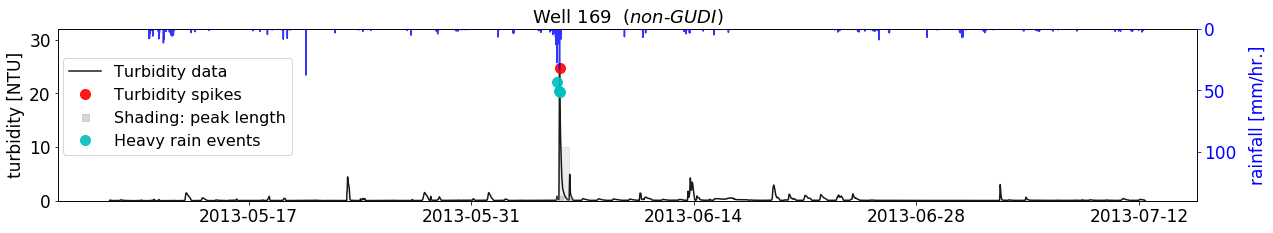

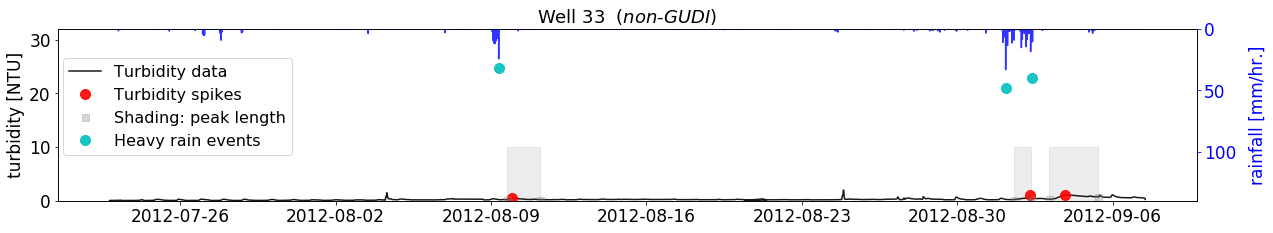

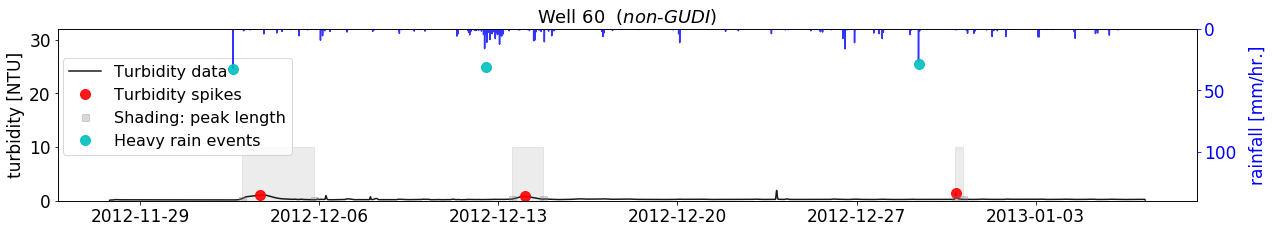

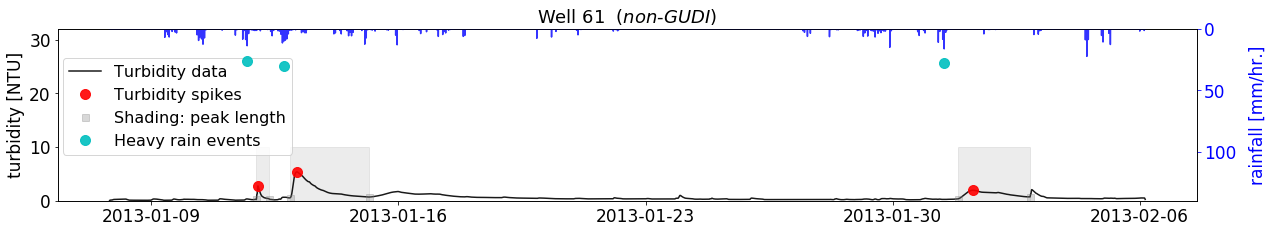

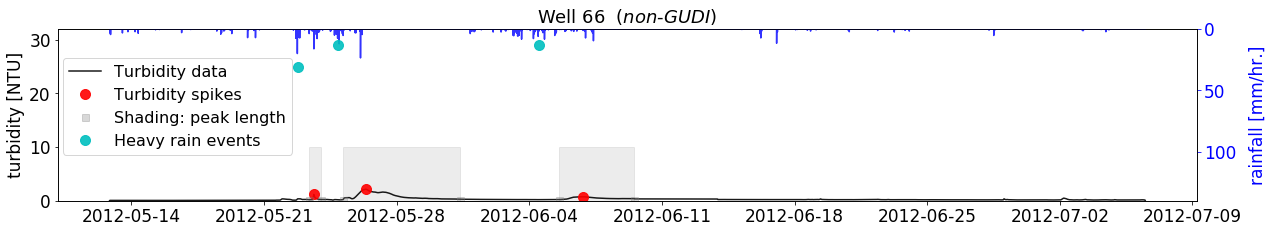

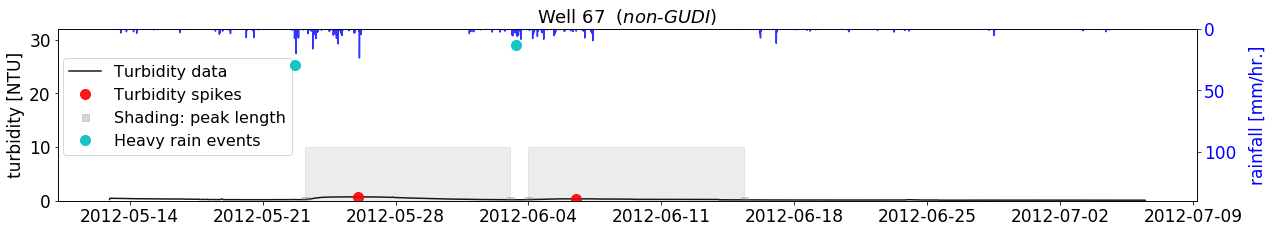

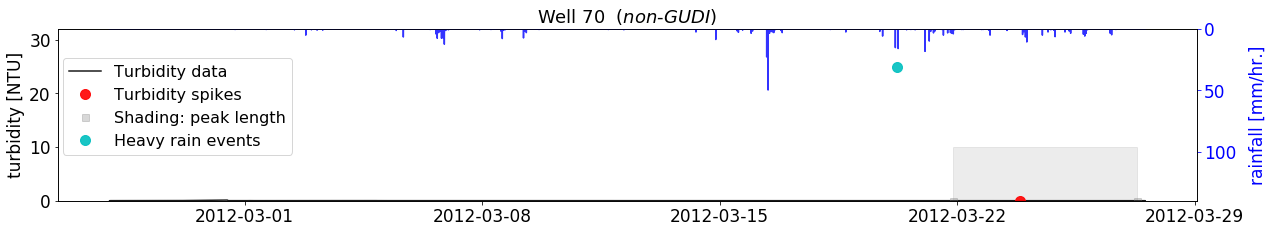

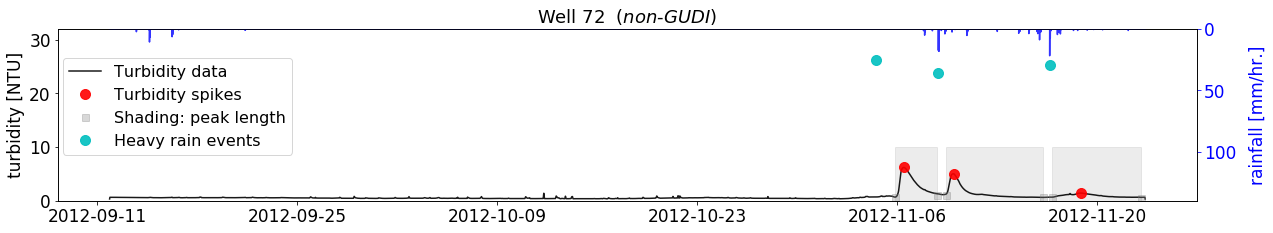

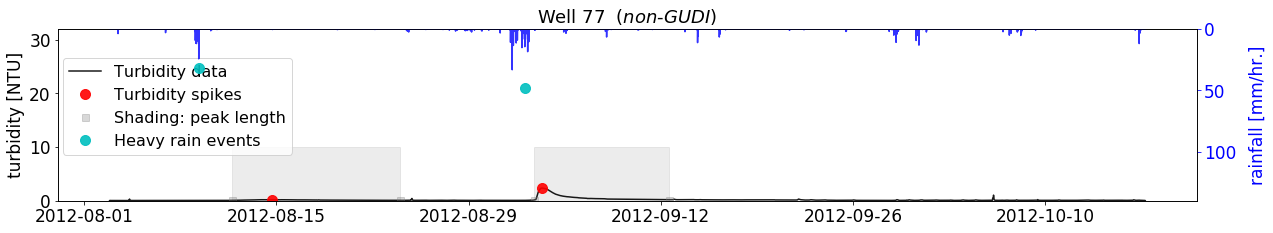

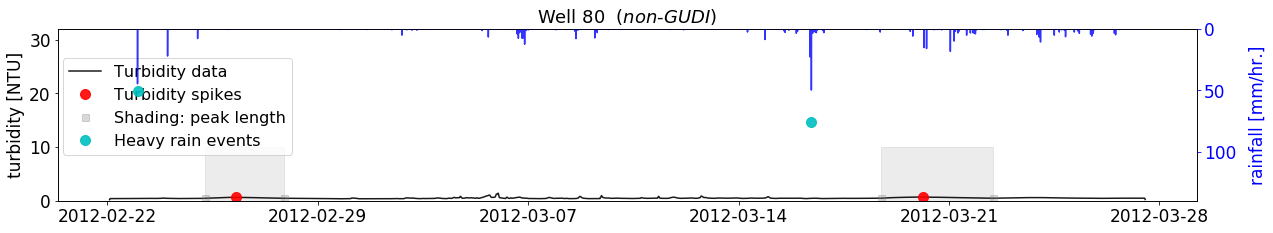

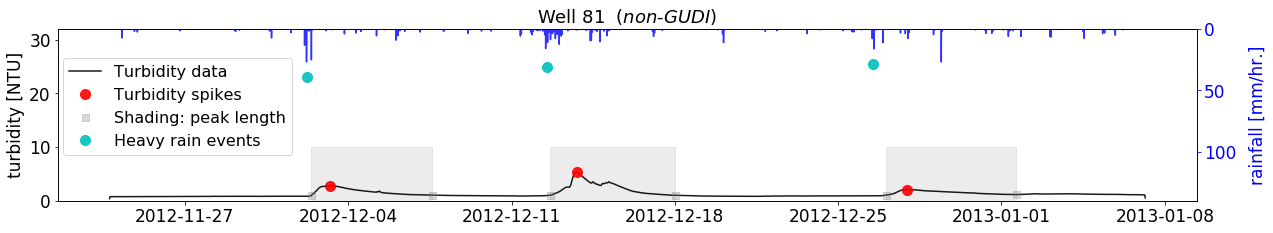

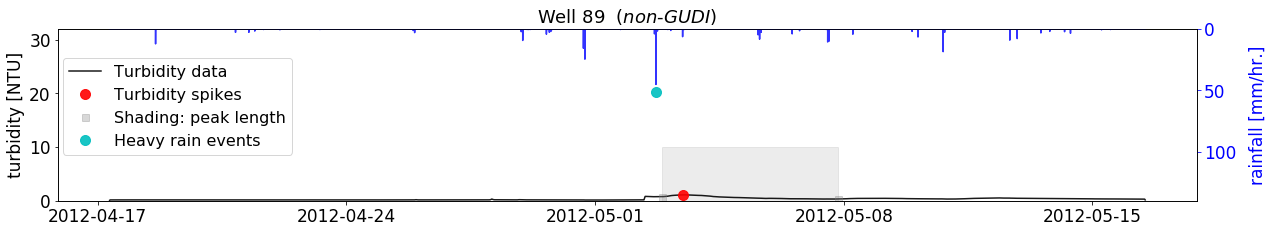

In [19]:
# final plots of data with spikes
plt.close("all")  # close previous figures to clear memory
os.chdir(homedir)

for i in list(spike_stats['Well']):    
    os.chdir(homedir)
    os.chdir(hand_processed)
    
#plot base NTU data
    fig = plt.figure(figsize=(18, 4))
    plt.rcParams.update({'font.size': 17})
    
    ax1 = plt.axes()
    ax1.set_ylabel('turbidity [NTU]', color='k', fontsize=17)
    ax1.tick_params('y', colors='k', labelsize=17)
    ax1.tick_params('x', colors='k', labelsize=17)
    
    #comment this out if you want to ignore original data    
#    ax1.plot(data[i]['date'], data[i]['filtered_NTU'], linestyle='-', marker='.', color='white', alpha=.2, label='')
    #this is the good data       
    ax1.plot(data[i]['date'], data[i]['double_filered_NTU'], linestyle='-',  color='k', alpha=.9, label='Turbidity data') 
 #   ax1.set_title(i+':  - ''number of peaks = ' + str(len(maxtab)))
 #   ax1.set_ylim(0,(data[i]['double_filered_NTU'].max()+data[i]['double_filered_NTU'].max()*.3))                        # this autoscales the top of the graph
    ax1.set_ylim(0, 32)                                                                                                   # no auto scaling 


# now plot rainfall #  
    ax2 = ax1.twinx()
  # ax2.plot(data[i]['date'], data[i]['daily_rain'], 'b-', alpha=0.4, marker='.')
  # ax2.plot(data[i]['date'], data[i]['PPG_Precip'], 'g-', alpha=0.4, marker='.')
    ax2.plot(data[i]['date'], data[i]['rain']*25.4, 'b-', alpha=0.8, label='')
    ax2.set_ylabel('rainfall [mm/hr.]', color='b', labelpad= 12, fontsize=17)
    ax2.tick_params('y', colors='b', labelsize=17)
    ax2.set_ylim(140,0)                                     # control the rainfall axis height (putting the max value first inverts it!)
    
# put the event and peak dots on the plots    
    dots = pd.read_csv(i+'_hand_processed.csv')
    dots = dots.dropna(subset = ['date'], axis=0, how='any')
    dots['date'] = pd.to_datetime(dots['date'], errors='coerce')
      
    ax1.plot(dots['date'], dots['NTU'], linestyle='None',  color='r', alpha=.9, marker='o', label='Turbidity spikes', markersize=10) # plot the peaks 
    
    ax2.plot(dots['date'], dots['Rol_sum_3hr']*25.4, linestyle='None',  color='c', alpha=.9, marker='o', label='Heavy rain events ', markersize=10)     # plot the rainfall as deliniated
  #  ax2.plot(data[i]['date'], data[i]['Rol_sum_3hr']*25.4, linestyle='None', label='Heavy rain events',color='c', alpha=.9, marker='o', markersize=9)   # plot the rainfall automatically 
    
    
    ax1.plot(dots['date'], dots['baseline_pts'], linestyle='None',  color='grey', alpha=.3, marker='s', label='Shading: peak length',  markersize=7) # plot the baseline pts/ boundaries of peaks 
    
# this block puts on shaded rectangles deliniating the start and end of each peak    
    t = dots['baseline_pts'].notnull()
    boundary_pts = dots[t]
    boundary_pts = boundary_pts.reset_index(drop=True)
    for v in list(boundary_pts.index):
        if (v % 2 == 0):                  # select the even index values these should always be the start of a peak
            startTime = pd.to_datetime(boundary_pts['date'][v], errors='coerce')
                
        if (v % 2 != 0):                  # select the odd values these should always be the end of a peak
            endTime = pd.to_datetime(boundary_pts['date'][v], errors='coerce')
                    
            start = mdates.date2num(startTime)   # these are to convert the date axis to something rectangle understands
            end = mdates.date2num(endTime)
            width = end - start                  
            rect = Rectangle((start, 0), width, 10, color='grey', alpha=.15)   # draw rectangle from start and make it width of 'width', a height of 10" of rain,  
            ax1.add_patch(rect)
    
#plot on ecoli dots              # comment out this block to 
#    ax3 = ax1.twinx()
#    ax3.plot(by_well_ecoli_data[i]['Date_and_time'], by_well_ecoli_data[i]['EC_count'], linestyle=':',  color='g', alpha=.6, marker='.', label='$E. coli$ counts', markersize=9)
#    ax3.tick_params('y', colors='g', pad = -38, direction='in', labelsize=16 )   # the  pad puts the ticks and numbers on inside of plot
#    ax3.set_ylabel('$E. coli$ [MPN/100 ml]', color='g', labelpad= -56, fontsize=14 )  # the label pad puts the label on inside of plot
#    ax3.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))   # get rid of stupid non-integer axis ticks
    # y axis scaling ideas comment one out
#    ax3.set_ylim((-1*by_well_ecoli_data[i]['EC_count'].max()*.1) , (by_well_ecoli_data[i]['EC_count'].max()+by_well_ecoli_data[i]['EC_count'].max()*.1))    # set limits to make numbers nice
#    ax3.set_ylim(-20,220)
    
     
# legend combination and handling for all axis          # COMMENTED OUT TO MODIFY TO REMOVE ECOLI AXIS
#    h1, l1 = ax1.get_legend_handles_labels()
#    h2, l2 = ax2.get_legend_handles_labels()
#    h3, l3 = ax3.get_legend_handles_labels()
#    ax1.legend(h1+h2+h3, l1+l2+l3, loc='center', bbox_to_anchor=(0.094, .55), ncol=1, fontsize=15)   # bbox controls legend placement - is outside of box

# legend combination and handling for all axis          # COMMENTED OUT TO MODIFY TO REMOVE ECOLI AXIS
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc='center', bbox_to_anchor=(0.105, .55), ncol=1, fontsize=16)   # bbox controls legend placement - is outside of box
    
           
# Shrink current axis to allow room for legend
    box = ax1.get_position()
    ax1.set_position([box.x0, box.y0*.1, box.width , box.height])
    
    plt.title('Well '+i.replace("W", "")+ "  ($non$-$GUDI)$", fontsize=18)
    plt.tight_layout()

# save each plot as a PDF 
    os.chdir(homedir)
    os.chdir(path_printed_plots)
    fig.savefig(i + '_.pdf', dpi=600)
    plt.show()    
    
    #print(by_well_ecoli_data[i]['EC_count'])

# Cell 6: Nice plots of non- GUDI wells without spikes

C:\Users\cshuler\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


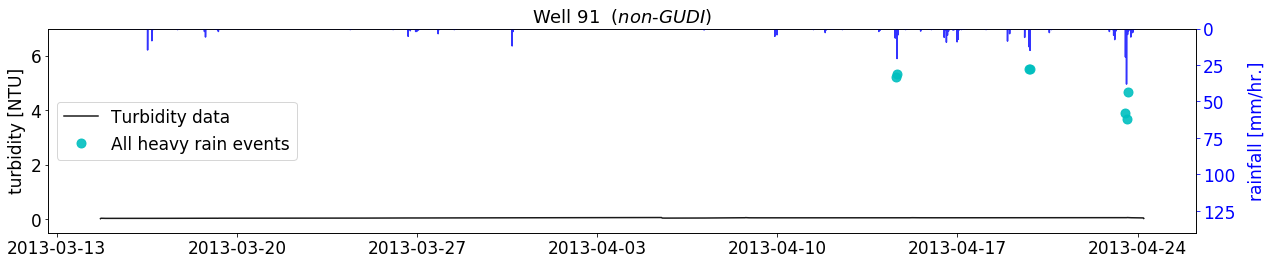

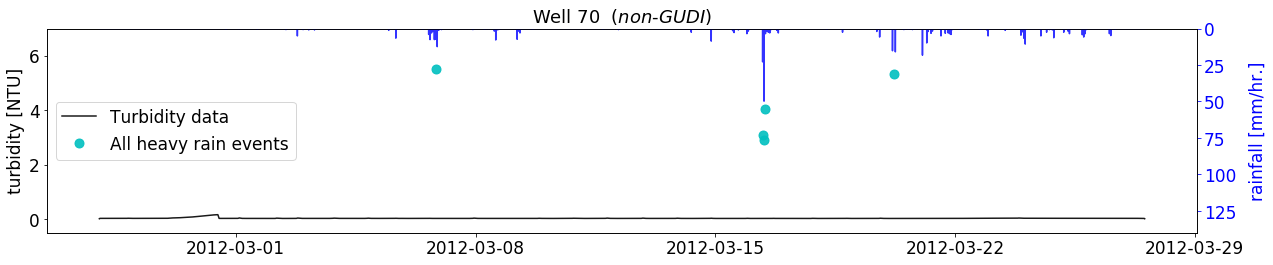

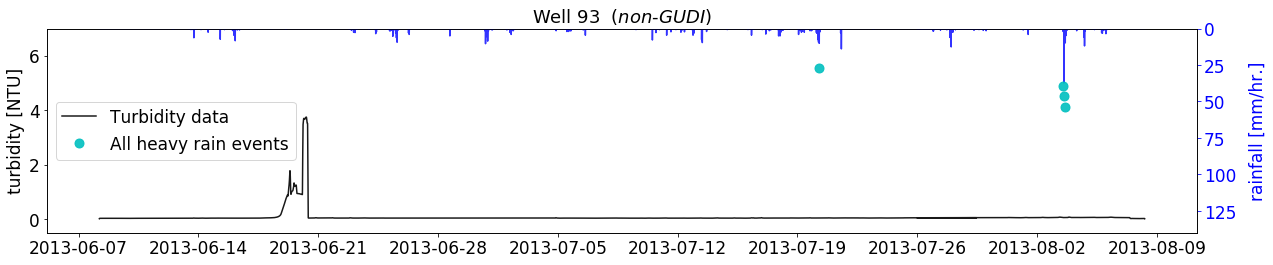

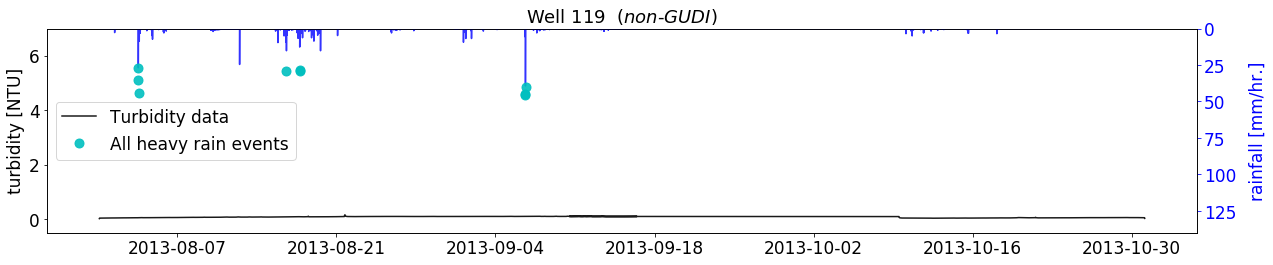

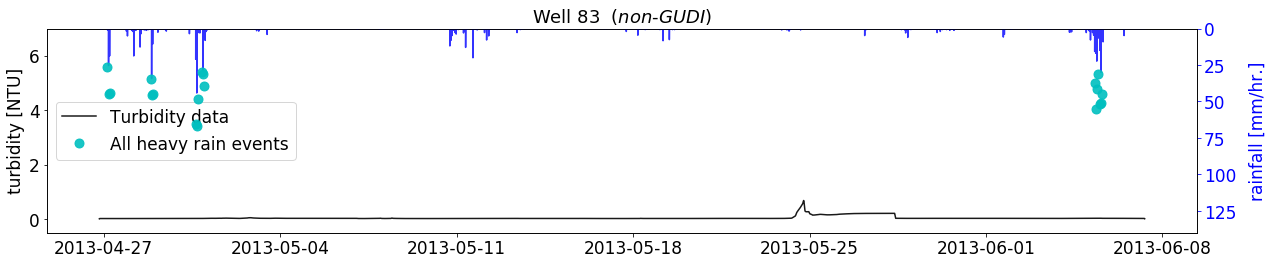

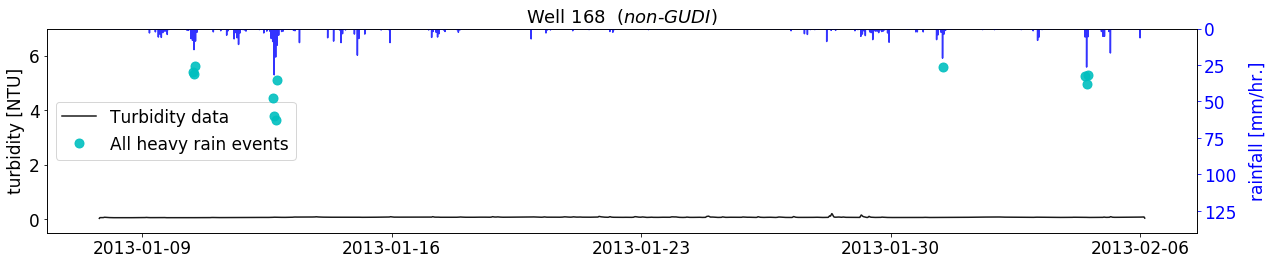

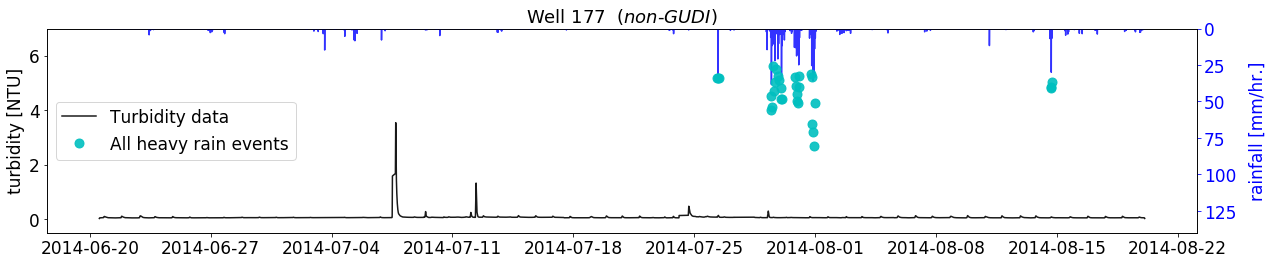

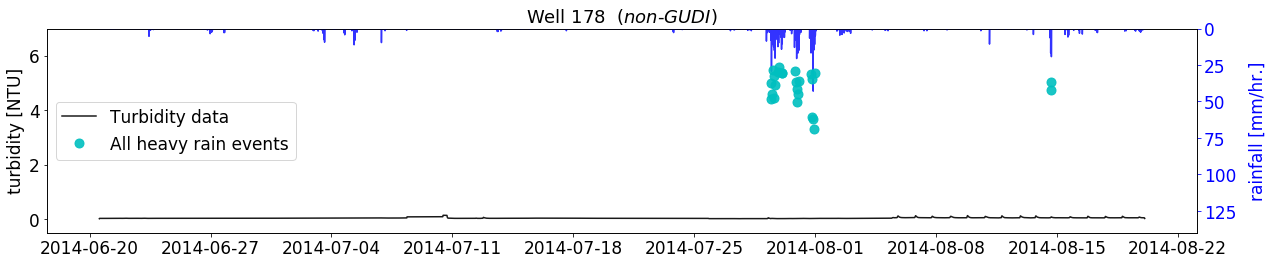

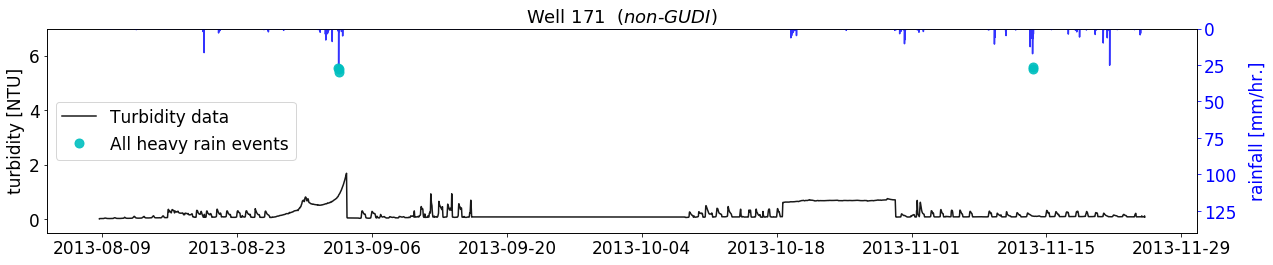

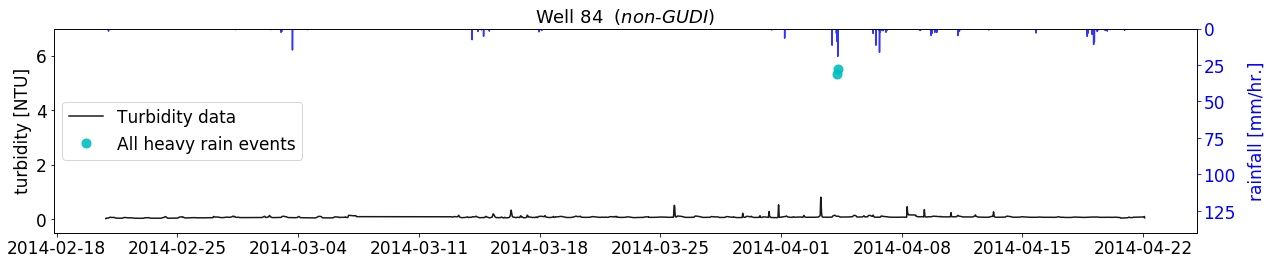

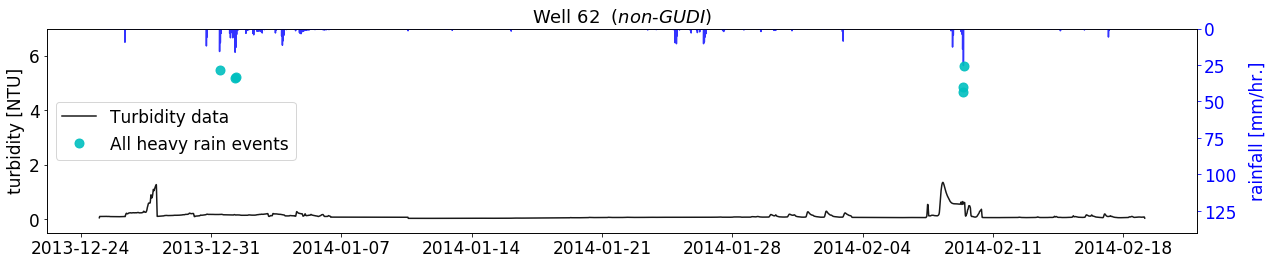

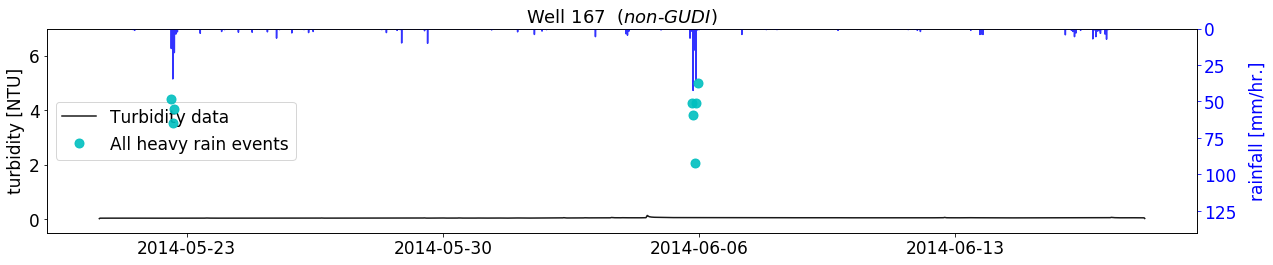

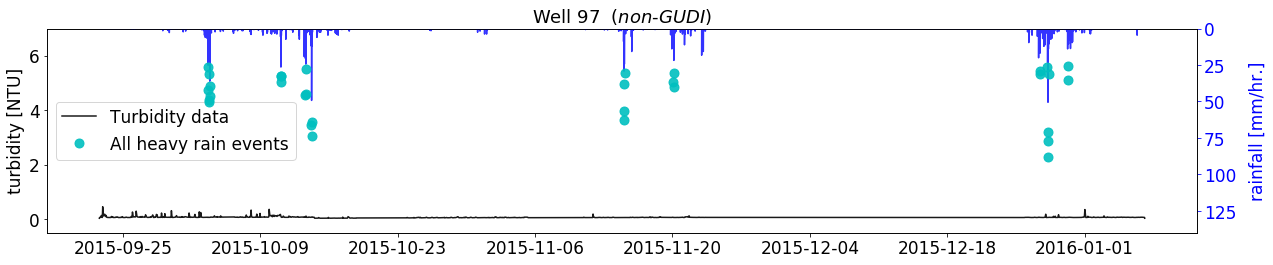

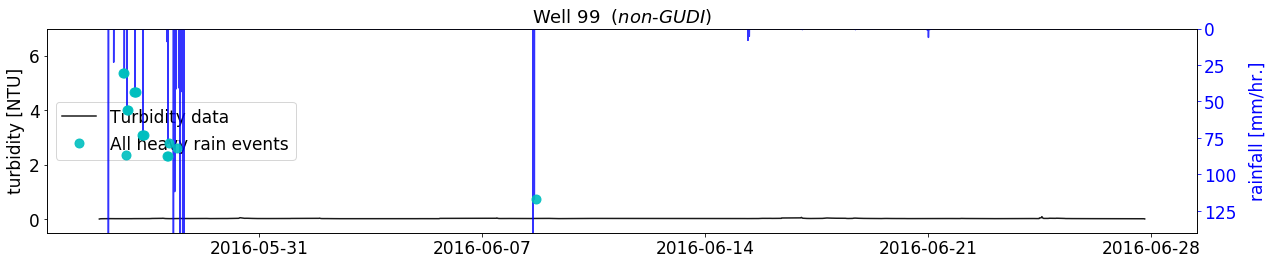

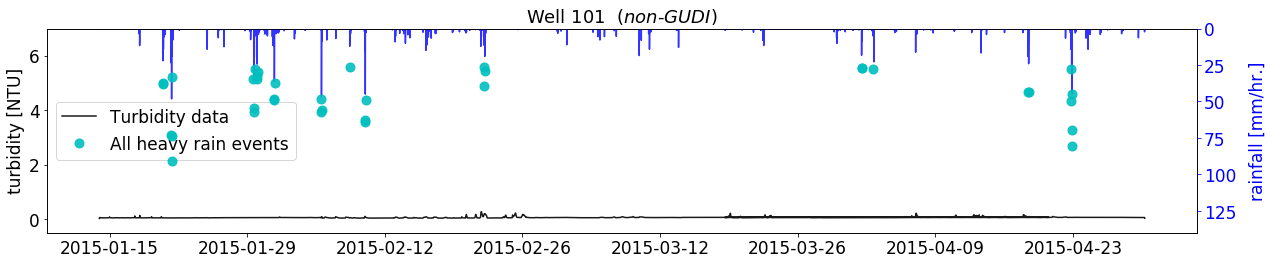

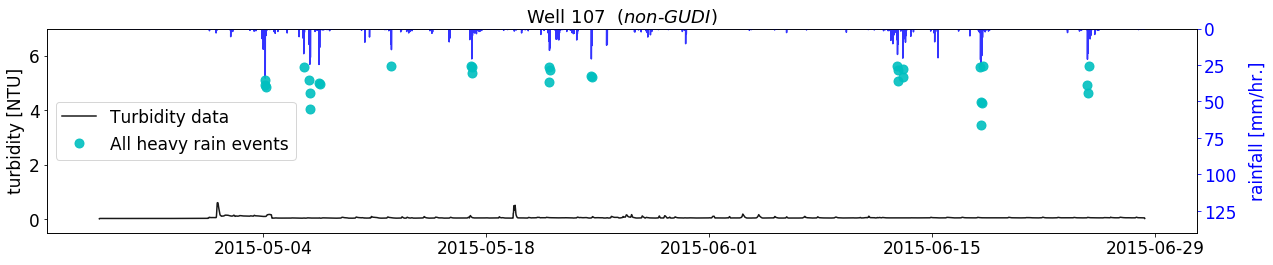

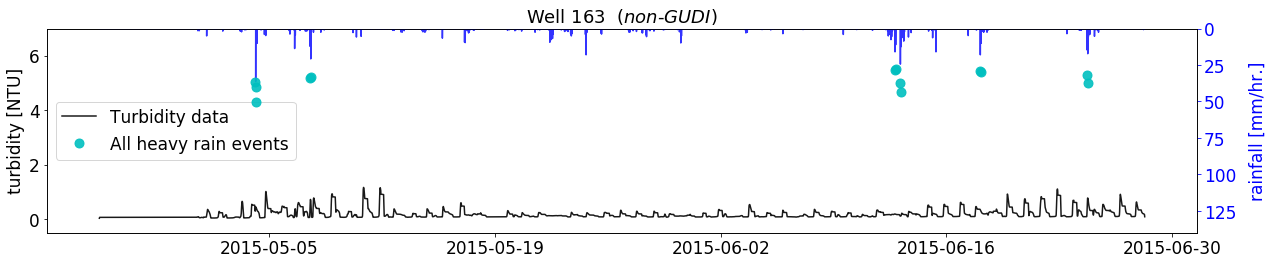

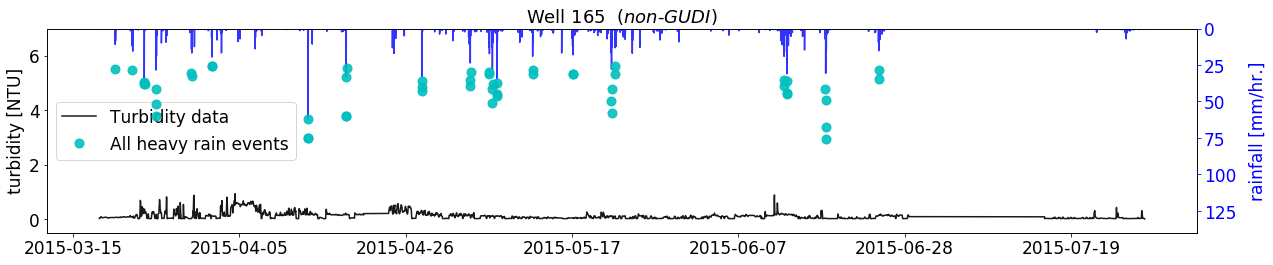

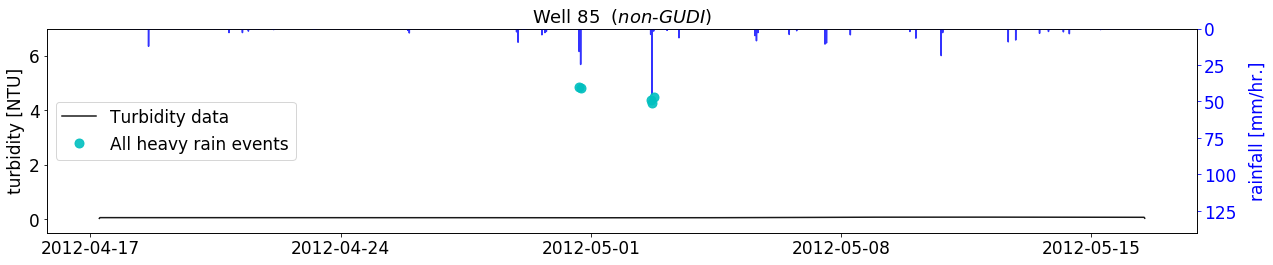

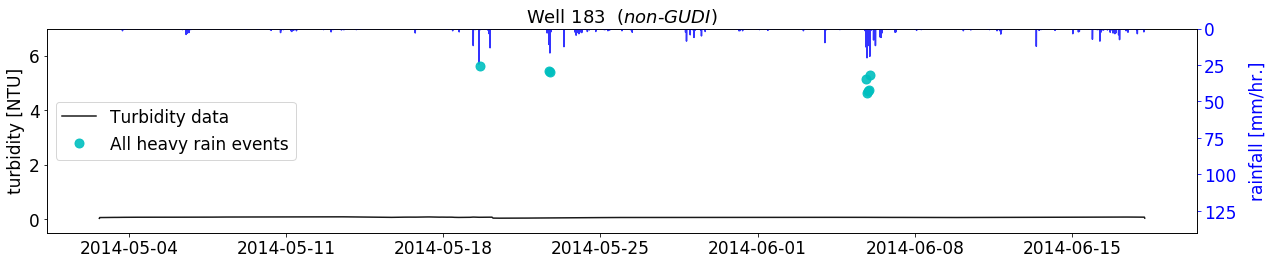

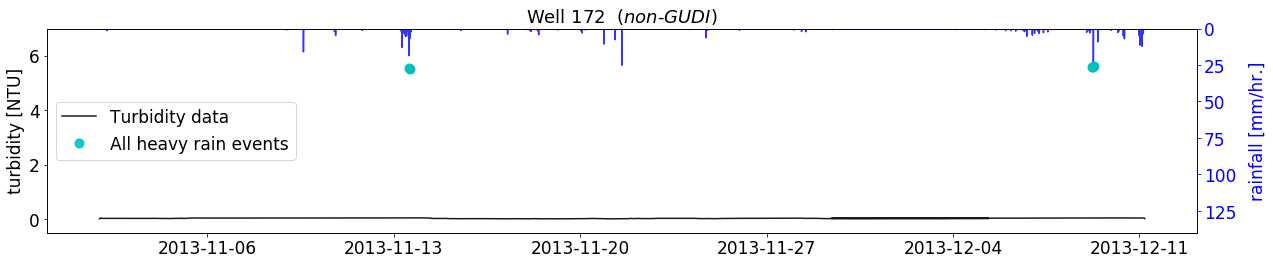

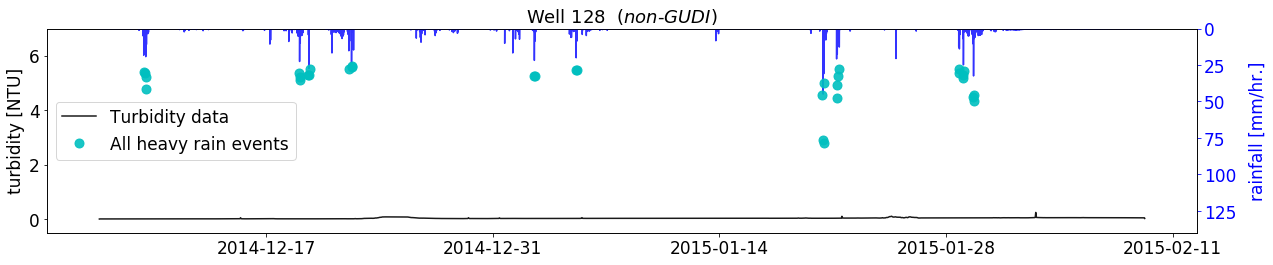

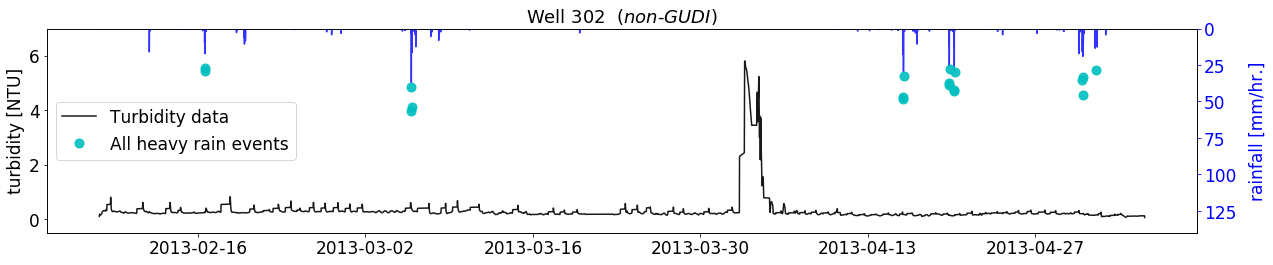

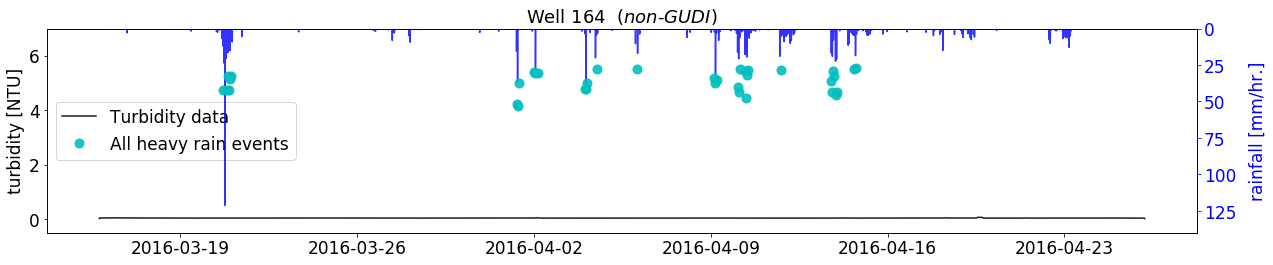

In [18]:
#Plot the wells without spikes
plt.close("all")  # close previous figures to clear memory

#define which wells are thought to have no spikes
no_spikes = ['W91', 'W70', 'W93', 'W119', 'W83', 'W168', 'W177', 'W178', 'W171', 'W84','W62','W167', 'W97', 'W99', 'W101', 'W107', 'W163','W165', 'W85','W183', 'W172', 'W128','W302', 'W164']


for i in no_spikes:
#plot base NTU data
    fig = plt.figure(figsize=(18, 4))
    plt.rcParams.update({'font.size': 17})
    
    ax1 = plt.axes()
    ax1.set_ylabel('turbidity [NTU]', color='k', fontsize=17)
    ax1.tick_params('y', colors='k', labelsize=17)
    ax1.tick_params('x', colors='k', labelsize=17)
    
    #comment this out if you want to ignore original data    
#    ax1.plot(data[i]['date'], data[i]['filtered_NTU'], linestyle='-', marker='.', color='white', alpha=.2, label='')
    #this is the good data       
    ax1.plot(data[i]['date'], data[i]['double_filered_NTU'], linestyle='-',  color='k', alpha=.9, label='Turbidity data') 
 #   ax1.set_title(i+':  - ''number of peaks = ' + str(len(maxtab)))
 #   ax1.set_ylim(0,(data[i]['double_filered_NTU'].max()+data[i]['double_filered_NTU'].max()*.3))                        # this autoscales the top of the graph
    ax1.set_ylim(-.5, 7) 
    
# now plot rainfall #  
    ax2 = ax1.twinx()
  # ax2.plot(data[i]['date'], data[i]['daily_rain'], 'b-', alpha=0.4, marker='.')
  # ax2.plot(data[i]['date'], data[i]['PPG_Precip'], 'g-', alpha=0.4, marker='.')
    ax2.plot(data[i]['date'], data[i]['rain']*25.4, 'b-', alpha=0.8, label='')
    ax2.set_ylabel('rainfall [mm/hr.]', color='b', labelpad= 12, fontsize=17)
    ax2.tick_params('y', colors='b', labelsize=17)
    ax2.set_ylim(140,0)                                     # control the rainfall axis height (putting the max value first inverts it!)
    
   
    #ax2.plot(data[i]['date'], data[i]['high_rain_rate_hrly'], linestyle='None', marker='o', color='y')          # plot high rainfall event dots
    ax2.plot(data[i]['date'], data[i]['Rol_sum_3hr']*25.4, linestyle='None', label='All heavy rain events',color='c', alpha=.9, marker='o', markersize=9)    
    
    
#plot on ecoli dots
#    ax3 = ax1.twinx()
#    ax3.plot(by_well_ecoli_data[i]['Date_and_time'], by_well_ecoli_data[i]['TC_count'], linestyle=':',  color='g', alpha=.6, marker='.', label='$E. coli$ counts', markersize=9)
#    ax3.tick_params('y', colors='g', pad = -38, direction='in', labelsize=16 )   # the  pad puts the ticks and numbers on inside of plot
#    ax3.set_ylabel('$E. coli$ [MPN/100 ml]', color='g', labelpad= -56, fontsize=14 )  # the label pad puts the label on inside of plot
#    ax3.yaxis.set_major_formatter(FormatStrFormatter("%.0f"))   # get rid of stupid non-integer axis ticks
    # y axis scaling ideas comment one out
#    ax3.set_ylim((-1*by_well_ecoli_data[i]['EC_count'].max()*.1) , (by_well_ecoli_data[i]['EC_count'].max()+by_well_ecoli_data[i]['EC_count'].max()*.1))    # set limits to make numbers nice
#    ax3.set_ylim(-40,220)
    
    
# for frustrating legend positioning
    #import time
   # from datetime import datetime
    #p = int(time.mktime(data[i]['date'][90].timetuple()))
        
# legend combination and handling 
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc=6)      
    
    plt.title('Well '+i.replace("W", "")+ "  ($non$-$GUDI)$", fontsize=18)
    plt.tight_layout()    
  
    os.chdir(homedir)
    os.chdir(path_printed_plots)
    fig.savefig(i + '_.pdf', dpi=600)